In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import phik
from phik import resources, report
from sklearn.preprocessing import KBinsDiscretizer
from feature_engine.discretisation import EqualFrequencyDiscretiser
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import (
    auc,
    roc_curve,
    f1_score,
    accuracy_score,
    classification_report,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve
)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import (
    KFold,
    RepeatedKFold,
    LeaveOneOut,
    LeavePOut,
    StratifiedKFold,
    GridSearchCV,
    train_test_split,
)
from sklearn import preprocessing
from feature_engine import imputation as mdi
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
    ADASYN,
    BorderlineSMOTE,
    SVMSMOTE,
)
from imblearn.ensemble import (
    BalancedBaggingClassifier,
    BalancedRandomForestClassifier,
    RUSBoostClassifier,
    EasyEnsembleClassifier,
)
from sklearn.feature_selection import f_classif
import ipaddress
import re
import category_encoders as ce
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import cross_val_score

* [Table of Contents](#Table_Contents)
* [1. Data](#Data)
    - [1 Imports](#Imports)
    - [2 Dataset Overview](#Dataset_Overview)
    - [3 Data Cleaning](#Data_Cleaning)
    - [4 Data Preprocession](#Data_Preprocession)
    - [5 Data Quality](#Data_Quality)
* [2. EDA](#EDA)
    - [1 Target](#Target)
    - [2 Continuous Numerical Features](#Continuous_Numerical_Features)
    - [3 Discrete Variable](#Discrete_Variable)
    - [3 Categorical_Variables](#Categorical_Variables)
    - [4 Relationship between variables](#Relationship_between_variables)
    - [5 Relationship between target and variables](#Relationship_between_target_and_variables)
    - [6 EDA Summary](#EDA_Summary)
* [3. Fraud_flag_Model](#Fraud_flag_Model)
    - [1 Train/Test_data_ready_for_modeling](#Train/Test_data_ready_for_modeling)
    - [2 Categorical_encoders_tuning_on_state](#Categorical_encoders_tuning_on_state)
    - [3 Feature_Selection](#Feature_Selection)
    - [4 RandomForest_Predict_Fraud_flag](#RandomForest_Predict_Fraud_flag)
    - [5 XGBoost_Predict_Fraud_flag](#XGBoost_Predict_Fraud_flag)
    - [6 Model_Selection](#Model_selection)
    - [7 Summary](#Summary)
* [4. Fraud_type_Model](#Fraud_type_Model)
    - [1 Train/Test_data_ready_for_modeling](#Train/Test_data_ready_for_modeling2)
    - [2 Feature_Selection](#Feature_Selection2)
    - [3 RandomForest_Predict_Fraud_type](#RandomForest_Predict_Fraud_type)
    - [4 Summary](#Summary2)
* [5. Conclusion](#Conclusion)

<a id='Data'></a>
<h2 style="background-color:#fbcc54;font-family:monospace;font-size:150%;text-align:center">1.Data</h2>

<a id='Imports'></a>
<h3 style="color:blue">1.1 Imports</h3>

In [2]:
#Read in provided training and validation files

transactions = 'transactions.csv'
t_df = pd.read_csv(transactions)

customers = 'customers.csv'
c_df = pd.read_csv(customers)
t_df

,customer_email,transaction_id,order_id,payment_method_id,payment_method_registration_failure,payment_method_type,payment_method_provider,transaction_amount,transaction_failed,order_state
0,JOSEPHHOWARD@YAHOO.COM,a9lcj51r,vjbdvd,wt07xm68b,1,card,JCB 16 digit,18,0,pending
1,joseph.howard@yahoo.com,y4wcv03i,yp6x27,wt07xm68b,1,card,JCB 16 digit,26,0,fulfilled
2,evansjeffery@yahoo.com,5mi94sfw,nlghpa,41ug157xz,0,bitcoin,American Express,45,0,fulfilled
3,evansjeffery@yahoo.com,br8ba1nu,uw0eeb,41ug157xz,0,bitcoin,American Express,23,0,fulfilled
4,evansjeffery@yahoo.com,a33145ss,bn44oh,y3xp697jx,1,bitcoin,VISA 16 digit,43,1,fulfilled
...,...,...,...,...,...,...,...,...,...,...
618,dawn05@tucker-brown.com,7yilsi1o,1bubxa,7yen1m1q8,0,card,VISA 13 digit,25,1,fulfilled
619,dawn05@tucker-brown.com,c82k5bcv,1bubxa,7yen1m1q8,0,card,VISA 13 digit,25,0,fulfilled
620,dawn05@tucker-brown.com,wmh52bns,1bubxa,3zmkegkb8,0,paypal,JCB 15 digit,25,1,fulfilled
621,dawn05@tucker-brown.com,xdw33hfp,p0gdbf,3zmkegkb8,0,paypal,JCB 15 digit,19,0,fulfilled


In [3]:
c_df

,customer_email,customer_phone,customer_device,customer_ip_address,customer_billing_address,transactions_count,orders_count,payments_count,fraud_flag,fraud_type,fraud_score
0,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",2,2,1,False,NaN,65
1,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,3,3,7,True,type_1,37
2,andersonwilliam@yahoo.com,024.420.0375,4m7h5ipl1shyavt6vv2r,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,"8478 Sean Ridges Apt. 441\nDavisberg, PR 72250",5,3,2,False,NaN,50
3,rubenjuarez@yahoo.com,670.664.8168x94985,slovx60t0i558may4ks0,95de:8565:5a66:792c:26e0:6cfb:7d87:11af,"7769 Elizabeth Bridge Apt. 343\nNortonstad, FM...",3,3,1,False,NaN,87
4,uchen@malone.com,1-981-877-0870,j0pd24k5h8dl2fqu0cz4,196.89.235.192,"148 Russell Lodge Apt. 445\nPort Jenniferside,...",7,7,6,True,type_1,4
...,...,...,...,...,...,...,...,...,...,...,...
163,mitchellvickie@brewer-jones.com,313-124-3836x3528,ecu7ezz0ue67v3fce1o3,181.90.104.120,"829 Ramirez Dam Suite 648\nGatesview, OR 55669...",3,3,1,True,type_1,44
164,sbrown@hughes.biz,(250)632-6631x02499,xgv918sclaz40qlp2fee,16.166.2.0,"9472 Pacheco Islands Suite 940\nDrewburgh, AZ ...",6,5,3,True,type_1,11
165,johnlowery@gmail.com,635.676.0955x524,969zz9zdj8z4gns4sx5p,f82c:811f:8a02:e2d6:79b:fcaa:42de:570b,"548 Bryant Inlet\nVeronicaside, OK 00522",4,4,2,True,type_1,9
166,ethompson@jackson-sanders.com,962.300.2250,navessqcnmc9csfjn5cj,203.246.172.244,"16953 Jennifer Springs\nKathybury, IL 02095-3215",8,6,6,True,type_1,49


<a id='Dataset_Overview'></a>
<h3 style="color:blue">1.2 Dataset Overview</h3> 

### Types of variables

In [4]:
t_df.dtypes

customer_email                         object
transaction_id                         object
order_id                               object
payment_method_id                      object
payment_method_registration_failure     int64
payment_method_type                    object
payment_method_provider                object
transaction_amount                      int64
transaction_failed                      int64
order_state                            object
dtype: object

In [5]:
c_df.dtypes

customer_email              object
customer_phone              object
customer_device             object
customer_ip_address         object
customer_billing_address    object
transactions_count           int64
orders_count                 int64
payments_count               int64
fraud_flag                    bool
fraud_type                  object
fraud_score                  int64
dtype: object

In [6]:
t_df.nunique()

customer_email                         138
transaction_id                         623
order_id                               478
payment_method_id                      237
payment_method_registration_failure      2
payment_method_type                      4
payment_method_provider                 10
transaction_amount                      68
transaction_failed                       2
order_state                              3
dtype: int64

There are categorical and numerical variables.

<a id='Data_Cleaning'></a>
<h3 style="color:blue">1.3 Data Cleaning</h3>

### Check Duplicates

In [7]:
# let's inspect the unique values 

for var in c_df.columns:
    print(var, c_df[var].nunique(), '\n')

customer_email 161 

customer_phone 168 

customer_device 168 

customer_ip_address 165 

customer_billing_address 166 

transactions_count 13 

orders_count 9 

payments_count 11 

fraud_flag 2 

fraud_type 2 

fraud_score 82 



customer_email, customer_ip_address, customer_billing_address have duplicates.

In [8]:
# Find the duplicated customer_billing_address values
repeated_billing_address = c_df[c_df['customer_billing_address'].duplicated()]
repeated_billing_address 

,customer_email,customer_phone,customer_device,customer_ip_address,customer_billing_address,transactions_count,orders_count,payments_count,fraud_flag,fraud_type,fraud_score
80,warrenedward@arnold.com,201.737.5119x64000,6py7ewqjkxjw8zjl9eri,45.203.99.249,49680 Brian Squares Apt. 122\nPort Walterburgh...,4,4,14,True,type_1,41
90,brittanydean@hotmail.com,6238721842,yq8xiivmx4prlgx0gofo,3517:8e52:885:8640:a59:f5fd:cb33:b06a,49680 Brian Squares Apt. 122\nPort Walterburgh...,6,4,1,True,type_2,23


In [9]:
# Find the duplicated customer_ip_address values
repeated_ip_address = c_df[c_df['customer_ip_address'].duplicated()]
repeated_ip_address

,customer_email,customer_phone,customer_device,customer_ip_address,customer_billing_address,transactions_count,orders_count,payments_count,fraud_flag,fraud_type,fraud_score
80,warrenedward@arnold.com,201.737.5119x64000,6py7ewqjkxjw8zjl9eri,45.203.99.249,49680 Brian Squares Apt. 122\nPort Walterburgh...,4,4,14,True,type_1,41
88,shelby24@hotmail.com,(071)934-3315x27613,obb41ux0zfa2td5ajo9s,45.203.99.249,"3271 Cynthia Groves\nPort Jeremyberg, CO 27305",5,4,2,True,type_2,33
141,christinemills@mcgee.com,(651)355-4709,zbn9it3s7yl69bjtrnqf,45.203.99.249,"5156 Greene Park Apt. 748\nNew Sandra, CA 1480...",5,5,2,True,type_1,57


In [10]:
# Find the duplicated customer_email values
repeated_emails = c_df[c_df['customer_email'].duplicated(keep=False)]
repeated_emails

,customer_email,customer_phone,customer_device,customer_ip_address,customer_billing_address,transactions_count,orders_count,payments_count,fraud_flag,fraud_type,fraud_score
7,johnlowery@gmail.com,044-642-9860,rjb0adai34izqvys4938,212.144.68.190,"484 Pamela Pass\nLake Jessicaview, WI 12942-9074",6,5,2,True,type_1,14
40,johnlowery@gmail.com,737-377-9701x577,jz66ap43id2y35ivfqa5,6c21:ac1d:2089:68fa:abb7:8c00:525f:6588,"08238 Kyle Squares Suite 893\nMillermouth, IN ...",0,0,1,True,type_1,12
45,johnlowery@gmail.com,+16(4)9016414340,cdx178qymd6vy77nm4x3,222.79.159.140,"77711 Pamela Ridge\nNew Kayla, IL 27182",3,2,1,True,type_1,23
65,johnlowery@gmail.com,4712252182,311kdz4c1210iixltk2j,42b3:df19:86fe:abd9:dafe:f6c1:eb76:c72,"11704 Andrew Villages Apt. 035\nJamesfurt, OR ...",7,5,1,True,type_1,7
79,johnlowery@gmail.com,1-820-539-4726x993,2in0fh7lep289n8dcbdz,163.128.139.42,"814 Wagner Union\nAshleymouth, HI 35617",2,2,1,True,type_1,34
133,johnlowery@gmail.com,1-143-059-1833,tyijaify2hqadwslejyr,e4c:fb48:8ee2:9819:6ae8:8d3f:3b6a:a788,"518 Wood Mews Apt. 970\nDillonstad, NE 43317-3945",0,0,0,True,type_1,55
155,johnlowery@gmail.com,076-099-0630x72770,6qy6oa3nqutsyyxzc54c,f259:657f:f329:2fca:c06c:8b57:d6ac:2380,"687 Rogers Bridge Suite 780\nValdezburgh, IN 2...",6,5,3,True,type_1,15
165,johnlowery@gmail.com,635.676.0955x524,969zz9zdj8z4gns4sx5p,f82c:811f:8a02:e2d6:79b:fcaa:42de:570b,"548 Bryant Inlet\nVeronicaside, OK 00522",4,4,2,True,type_1,9


In [11]:
repeated_emails_agg=repeated_emails.groupby(['customer_email']).agg(customer_phone=('customer_phone', 'first'),
                                                customer_device=('customer_device', 'first'),
                                                customer_ip_address=('customer_ip_address', 'first'),
                                                customer_billing_address=('customer_billing_address', 'first'),
                                                transactions_count=('transactions_count', 'sum'),
                                                orders_count=('orders_count', 'sum'),
                                                payments_count=('payments_count', 'sum'),
                                                fraud_flag=('fraud_flag', 'first'),
                                                fraud_type=('fraud_type', 'first'),
                                                fraud_score=('fraud_score', 'max'))

repeated_emails_agg.reset_index(inplace=True)


In [12]:
repeated_emails_agg

,customer_email,customer_phone,customer_device,customer_ip_address,customer_billing_address,transactions_count,orders_count,payments_count,fraud_flag,fraud_type,fraud_score
0,johnlowery@gmail.com,044-642-9860,rjb0adai34izqvys4938,212.144.68.190,"484 Pamela Pass\nLake Jessicaview, WI 12942-9074",28,23,11,True,type_1,55


In [13]:
# Delete the rows with repeated email addresses from the original DataFrame
customer = c_df[~c_df['customer_email'].duplicated()]

# Concatenate the original DataFrame without repeated emails and the aggregated rows
customer = pd.concat([customer, repeated_emails_agg], ignore_index=True)


# Print the updated DataFrame
customer

,customer_email,customer_phone,customer_device,customer_ip_address,customer_billing_address,transactions_count,orders_count,payments_count,fraud_flag,fraud_type,fraud_score
0,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",2,2,1,False,NaN,65
1,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,3,3,7,True,type_1,37
2,andersonwilliam@yahoo.com,024.420.0375,4m7h5ipl1shyavt6vv2r,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,"8478 Sean Ridges Apt. 441\nDavisberg, PR 72250",5,3,2,False,NaN,50
3,rubenjuarez@yahoo.com,670.664.8168x94985,slovx60t0i558may4ks0,95de:8565:5a66:792c:26e0:6cfb:7d87:11af,"7769 Elizabeth Bridge Apt. 343\nNortonstad, FM...",3,3,1,False,NaN,87
4,uchen@malone.com,1-981-877-0870,j0pd24k5h8dl2fqu0cz4,196.89.235.192,"148 Russell Lodge Apt. 445\nPort Jenniferside,...",7,7,6,True,type_1,4
...,...,...,...,...,...,...,...,...,...,...,...
157,mitchellvickie@brewer-jones.com,313-124-3836x3528,ecu7ezz0ue67v3fce1o3,181.90.104.120,"829 Ramirez Dam Suite 648\nGatesview, OR 55669...",3,3,1,True,type_1,44
158,sbrown@hughes.biz,(250)632-6631x02499,xgv918sclaz40qlp2fee,16.166.2.0,"9472 Pacheco Islands Suite 940\nDrewburgh, AZ ...",6,5,3,True,type_1,11
159,ethompson@jackson-sanders.com,962.300.2250,navessqcnmc9csfjn5cj,203.246.172.244,"16953 Jennifer Springs\nKathybury, IL 02095-3215",8,6,6,True,type_1,49
160,dawn05@tucker-brown.com,(089)703-7360x8848,lu4fgcug8dr0dwbcuui1,132.132.95.33,"130 Kimberly Junctions\nEricmouth, KS 59756-2919",7,5,4,False,NaN,91


#### Duplicated customer_email, customer_ip_address, customer_billing_address are high chance to be fraud.

<a id='Data_Preprocession'></a>
<h3 style="color:blue">1.4 Data Preprocession</h3>

### a.In customers table, calculate total successful transaction amount by each customer.

In [14]:
# Filter successful transactions
successful_transactions = t_df[t_df['transaction_failed'] == 0]

# Group transactions by customer_email and sum the transaction amounts
total_successful_amount = successful_transactions.groupby('customer_email')['transaction_amount'].sum()

# Merge the total_successful_amount with the customers DataFrame
customer = pd.merge(customer, total_successful_amount, on='customer_email', how='left')

# Print the resulting DataFrame with customer email and total successful transaction amount
customer[['customer_email', 'transaction_amount']]

,customer_email,transaction_amount
0,josephhoward@yahoo.com,NaN
1,evansjeffery@yahoo.com,68.0
2,andersonwilliam@yahoo.com,82.0
3,rubenjuarez@yahoo.com,85.0
4,uchen@malone.com,299.0
...,...,...
157,mitchellvickie@brewer-jones.com,126.0
158,sbrown@hughes.biz,135.0
159,ethompson@jackson-sanders.com,287.0
160,dawn05@tucker-brown.com,126.0


### b. In transactions table, we define “good customers” as customers who never failed any transactions. Return the good customer list.

In [15]:
# Group transactions by customer_email and check if any transaction has failed
failed_transactions = t_df.groupby('customer_email')['transaction_failed'].any()

# Filter 'customer' DataFrame based on customers with no failed transactions
good_customers = customer[~customer['customer_email'].isin(failed_transactions[failed_transactions].index)]

# Print the resulting DataFrame with good customers
good_customers[['customer_email']]

,customer_email
0,josephhoward@yahoo.com
3,rubenjuarez@yahoo.com
5,robinsoncynthia@dunn.com
9,ubranch@rivera-parker.info
12,christineklein@wright-boyd.org
...,...
145,philipnelson@dean.com
148,kwalsh@lopez-gomez.biz
151,daniel98@lamb.com
154,deborah38@yahoo.com


### New feature: 'transaction_failed','payment_method_registration_failure'

In [16]:
transaction_failed = t_df.groupby('customer_email')['transaction_failed'].sum()
payment_registration_failed = t_df.groupby('customer_email')['payment_method_registration_failure'].sum()

merge = pd.merge(customer, transaction_failed, on='customer_email', how='left')
merge = pd.merge(merge, payment_registration_failed, on='customer_email', how='left')


# Print the resulting DataFrame with customer email and total successful transaction amount
merge[['customer_email', 'transaction_failed','payment_method_registration_failure']]

,customer_email,transaction_failed,payment_method_registration_failure
0,josephhoward@yahoo.com,NaN,NaN
1,evansjeffery@yahoo.com,1.0,1.0
2,andersonwilliam@yahoo.com,2.0,0.0
3,rubenjuarez@yahoo.com,0.0,0.0
4,uchen@malone.com,2.0,0.0
...,...,...,...
157,mitchellvickie@brewer-jones.com,0.0,0.0
158,sbrown@hughes.biz,1.0,0.0
159,ethompson@jackson-sanders.com,2.0,0.0
160,dawn05@tucker-brown.com,2.0,0.0


### perform one-hot encoding on the 'payment_method_type', 'payment_method_provider'

In [17]:

onehotfeatures = ['payment_method_type', 'payment_method_provider']
transaction = t_df[t_df['payment_method_registration_failure']==0]
one_hot_merged = pd.get_dummies(transaction[onehotfeatures], prefix=onehotfeatures)
one_hot_merged = pd.concat([transaction['customer_email'], one_hot_merged], axis=1)

In [18]:
one_hot_merged = one_hot_merged.groupby('customer_email').agg('sum')
one_hot_merged

,payment_method_type_apple pay,payment_method_type_bitcoin,payment_method_type_card,payment_method_type_paypal,payment_method_provider_American Express,payment_method_provider_Diners Club / Carte Blanche,payment_method_provider_Discover,payment_method_provider_JCB 15 digit,payment_method_provider_JCB 16 digit,payment_method_provider_Maestro,payment_method_provider_Mastercard,payment_method_provider_VISA 13 digit,payment_method_provider_VISA 16 digit,payment_method_provider_Voyager
customer_email,,,,,,,,,,,,,,
1yf0@jedyz63t,0,0,7,3,0,0,0,0,0,1,3,6,0,0
9es7t@u6n7x,0,0,2,0,0,0,0,0,0,0,0,0,0,2
abigail08@yahoo.com,0,0,4,0,0,0,0,0,0,0,0,0,4,0
alec27@bell.com,0,0,6,0,0,0,0,0,0,0,0,0,2,4
aliciaanthony@martin.com,0,0,3,0,0,0,0,0,0,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wdelacruz@yahoo.com,0,0,4,0,0,0,0,0,4,0,0,0,0,0
whitedavid@jones-lloyd.org,0,0,2,0,0,0,0,0,2,0,0,0,0,0
ybrown@gmail.com,0,0,5,0,0,0,0,0,3,0,0,0,1,1


In [19]:
df= pd.merge(merge, one_hot_merged, on='customer_email', how='left')
df

,customer_email,customer_phone,customer_device,customer_ip_address,customer_billing_address,transactions_count,orders_count,payments_count,fraud_flag,fraud_type,...,payment_method_provider_American Express,payment_method_provider_Diners Club / Carte Blanche,payment_method_provider_Discover,payment_method_provider_JCB 15 digit,payment_method_provider_JCB 16 digit,payment_method_provider_Maestro,payment_method_provider_Mastercard,payment_method_provider_VISA 13 digit,payment_method_provider_VISA 16 digit,payment_method_provider_Voyager
0,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",2,2,1,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,3,3,7,True,type_1,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,andersonwilliam@yahoo.com,024.420.0375,4m7h5ipl1shyavt6vv2r,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,"8478 Sean Ridges Apt. 441\nDavisberg, PR 72250",5,3,2,False,NaN,...,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
3,rubenjuarez@yahoo.com,670.664.8168x94985,slovx60t0i558may4ks0,95de:8565:5a66:792c:26e0:6cfb:7d87:11af,"7769 Elizabeth Bridge Apt. 343\nNortonstad, FM...",3,3,1,False,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,uchen@malone.com,1-981-877-0870,j0pd24k5h8dl2fqu0cz4,196.89.235.192,"148 Russell Lodge Apt. 445\nPort Jenniferside,...",7,7,6,True,type_1,...,1.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,mitchellvickie@brewer-jones.com,313-124-3836x3528,ecu7ezz0ue67v3fce1o3,181.90.104.120,"829 Ramirez Dam Suite 648\nGatesview, OR 55669...",3,3,1,True,type_1,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
158,sbrown@hughes.biz,(250)632-6631x02499,xgv918sclaz40qlp2fee,16.166.2.0,"9472 Pacheco Islands Suite 940\nDrewburgh, AZ ...",6,5,3,True,type_1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
159,ethompson@jackson-sanders.com,962.300.2250,navessqcnmc9csfjn5cj,203.246.172.244,"16953 Jennifer Springs\nKathybury, IL 02095-3215",8,6,6,True,type_1,...,2.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,3.0
160,dawn05@tucker-brown.com,(089)703-7360x8848,lu4fgcug8dr0dwbcuui1,132.132.95.33,"130 Kimberly Junctions\nEricmouth, KS 59756-2919",7,5,4,False,NaN,...,0.0,0.0,0.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0


### New Feature: label_ip_type

In [20]:

def label_ip_type(ip):
    try:
        ip_obj = ipaddress.ip_address(ip)
        if ip_obj.version == 4:
            return 'IPv4'
        elif ip_obj.version == 6:
            return 'IPv6'
        else:
            return None
    except ValueError:
        return None

# Apply the labeling function to the 'ip' column
df['customer_ip_address'] = df['customer_ip_address'].apply(label_ip_type)


### New Feature: state

In [21]:
import re

def extract_state(address):
    state_pattern = r',\s*([A-Z]{2})\s'
    match = re.search(state_pattern, address)
    if match:
        state = match.group(1)
        return state
    elif any(keyword in address for keyword in ["FPO", "APO", "AA", "AP","AE"]):
        return "Military"
    else:
        return None

    
df['state'] = df['customer_billing_address'].apply(extract_state)
df

,customer_email,customer_phone,customer_device,customer_ip_address,customer_billing_address,transactions_count,orders_count,payments_count,fraud_flag,fraud_type,...,payment_method_provider_Diners Club / Carte Blanche,payment_method_provider_Discover,payment_method_provider_JCB 15 digit,payment_method_provider_JCB 16 digit,payment_method_provider_Maestro,payment_method_provider_Mastercard,payment_method_provider_VISA 13 digit,payment_method_provider_VISA 16 digit,payment_method_provider_Voyager,state
0,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,IPv4,"5493 Jones Islands\nBrownside, CA 51896",2,2,1,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CA
1,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,IPv4,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,3,3,7,True,type_1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NM
2,andersonwilliam@yahoo.com,024.420.0375,4m7h5ipl1shyavt6vv2r,IPv6,"8478 Sean Ridges Apt. 441\nDavisberg, PR 72250",5,3,2,False,NaN,...,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,PR
3,rubenjuarez@yahoo.com,670.664.8168x94985,slovx60t0i558may4ks0,IPv6,"7769 Elizabeth Bridge Apt. 343\nNortonstad, FM...",3,3,1,False,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,FM
4,uchen@malone.com,1-981-877-0870,j0pd24k5h8dl2fqu0cz4,IPv4,"148 Russell Lodge Apt. 445\nPort Jenniferside,...",7,7,6,True,type_1,...,0.0,0.0,0.0,3.0,0.0,0.0,1.0,2.0,0.0,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,mitchellvickie@brewer-jones.com,313-124-3836x3528,ecu7ezz0ue67v3fce1o3,IPv4,"829 Ramirez Dam Suite 648\nGatesview, OR 55669...",3,3,1,True,type_1,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,OR
158,sbrown@hughes.biz,(250)632-6631x02499,xgv918sclaz40qlp2fee,IPv4,"9472 Pacheco Islands Suite 940\nDrewburgh, AZ ...",6,5,3,True,type_1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,AZ
159,ethompson@jackson-sanders.com,962.300.2250,navessqcnmc9csfjn5cj,IPv4,"16953 Jennifer Springs\nKathybury, IL 02095-3215",8,6,6,True,type_1,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,3.0,IL
160,dawn05@tucker-brown.com,(089)703-7360x8848,lu4fgcug8dr0dwbcuui1,IPv4,"130 Kimberly Junctions\nEricmouth, KS 59756-2919",7,5,4,False,NaN,...,0.0,0.0,3.0,1.0,0.0,0.0,3.0,0.0,0.0,KS


In [22]:
df = df.drop(columns=['customer_email','customer_phone', 'customer_device', 'customer_billing_address'])

### Types of variables

In [23]:
# Numerical: discrete vs continuous
discrete_num = [var for var in df.columns if (df[var].dtype != 'O' and var not in ['fraud_flag', 'fraud_type'] and df[var].nunique() < 10)]
continuous_num = [var for var in df.columns if (df[var].dtype != 'O' and var not in ['fraud_flag', 'fraud_type'] and var not in discrete_num)]

# Categorical
categorical = [var for var in df.columns if (df[var].dtype == 'O' and var not in ['fraud_flag', 'fraud_type'])]

print('There are {} discrete numerical variables'.format(len(discrete_num)))
print('There are {} continuous numerical variables'.format(len(continuous_num)))
print('There are {} categorical variables'.format(len(categorical)))

There are 15 discrete numerical variables
There are 6 continuous numerical variables
There are 2 categorical variables


In [24]:
discrete_num

['transaction_failed',
 'payment_method_registration_failure',
 'payment_method_type_apple pay',
 'payment_method_type_bitcoin',
 'payment_method_type_paypal',
 'payment_method_provider_American Express',
 'payment_method_provider_Diners Club / Carte Blanche',
 'payment_method_provider_Discover',
 'payment_method_provider_JCB 15 digit',
 'payment_method_provider_JCB 16 digit',
 'payment_method_provider_Maestro',
 'payment_method_provider_Mastercard',
 'payment_method_provider_VISA 13 digit',
 'payment_method_provider_VISA 16 digit',
 'payment_method_provider_Voyager']

In [25]:
continuous_num

['transactions_count',
 'orders_count',
 'payments_count',
 'fraud_score',
 'transaction_amount',
 'payment_method_type_card']

In [26]:
categorical

['customer_ip_address', 'state']

In [27]:
# let's inspect the variable values

for var in df.columns:
    print(var, df[var].unique()[0:10], '\n')

customer_ip_address ['IPv4' 'IPv6'] 

transactions_count [ 2  3  5  7  1  6  0  4  8 11] 

orders_count [ 2  3  7  1  5  0  4  6  8 23] 

payments_count [ 1  7  2  6  4  3  0 15 14 13] 

fraud_flag [False  True] 

fraud_type [nan 'type_1' 'type_2'] 

fraud_score [65 37 50 87  4 22 16 14 18 24] 

transaction_amount [ nan  68.  82.  85. 299.  25.  40. 763.  46. 116.] 

transaction_failed [nan  1.  2.  0.  6.  3.  5.  4. 12.] 

payment_method_registration_failure [nan  1.  0.  4.  5.  6.  2.  3. 13.] 

payment_method_type_apple pay [nan  0.  3.  2.  4.  1.  6.] 

payment_method_type_bitcoin [nan  2.  0.  1.  3.  4.] 

payment_method_type_card [nan  0.  5.  3.  4.  1. 24.  6.  2.  8.] 

payment_method_type_paypal [nan  0.  1.  2.  3.  5.  4.] 

payment_method_provider_American Express [nan  2.  0.  1.  3.  4.  7.] 

payment_method_provider_Diners Club / Carte Blanche [nan  0.  2.  1.  4. 15.  3.] 

payment_method_provider_Discover [nan  0.  1.  5.  6.  2.  3.] 

payment_method_provider_JCB

<a id='Data_Quality'></a>
<h3 style="color:blue">1.5 Data Quality</h3>

### Missing data

In [28]:
df.isnull().sum()

customer_ip_address                                      0
transactions_count                                       0
orders_count                                             0
payments_count                                           0
fraud_flag                                               0
fraud_type                                             107
fraud_score                                              0
transaction_amount                                      29
transaction_failed                                      26
payment_method_registration_failure                     26
payment_method_type_apple pay                           36
payment_method_type_bitcoin                             36
payment_method_type_card                                36
payment_method_type_paypal                              36
payment_method_provider_American Express                36
payment_method_provider_Diners Club / Carte Blanche     36
payment_method_provider_Discover                        

### Outliers

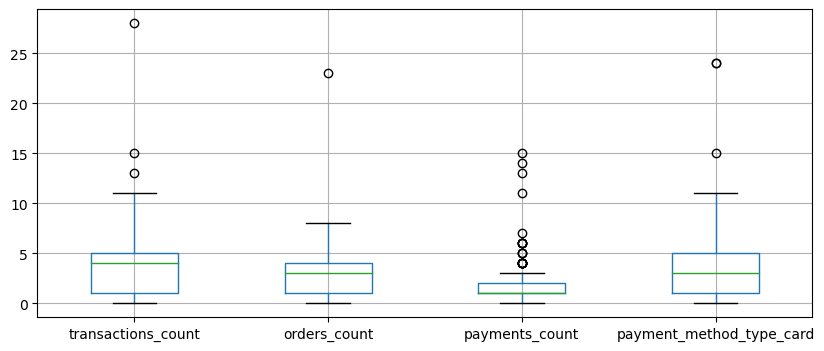

In [29]:
df[['transactions_count', 'orders_count', 'payments_count','payment_method_type_card']].boxplot(figsize=(10,4))
plt.show()

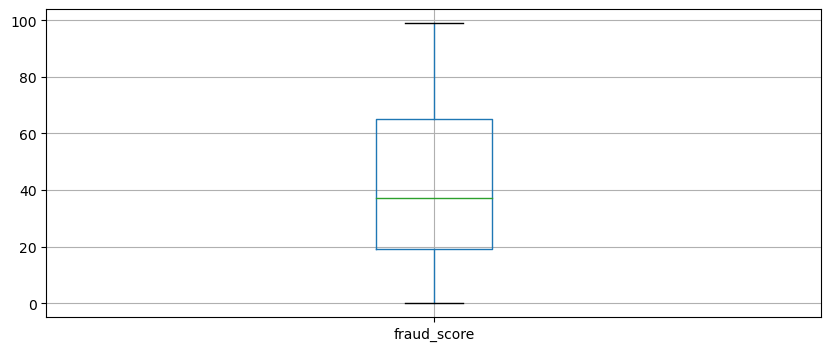

In [30]:
df[['fraud_score']].boxplot(figsize=(10,4))
plt.show()

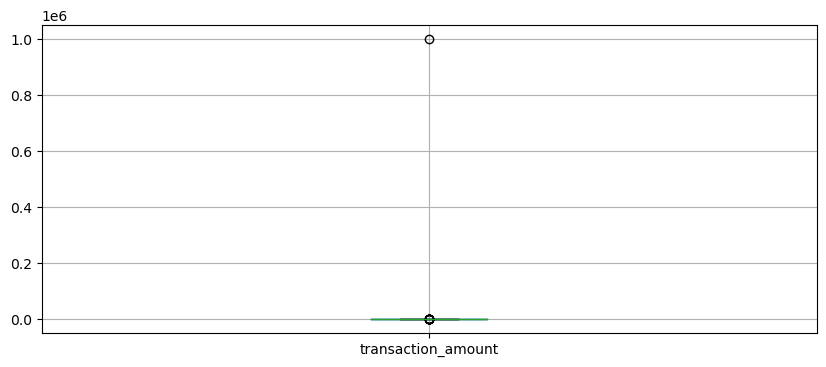

In [31]:
df[['transaction_amount']].boxplot(figsize=(10,4))
plt.show()

One extreme transaction amount, del the max one and visualize again

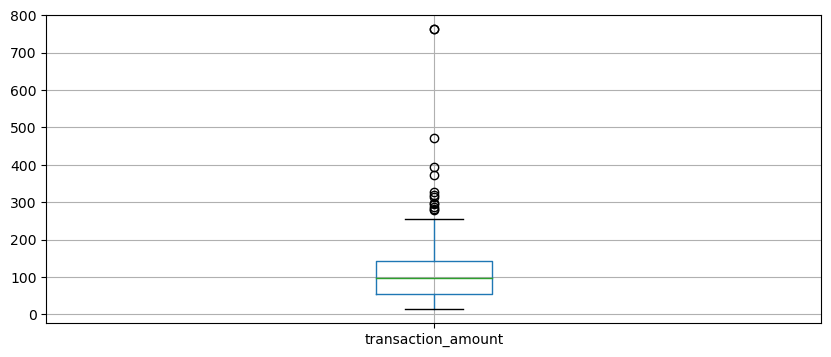

In [32]:
# Delete the maximum transaction amount
max_transaction_amount = df['transaction_amount'].max()
transaction_amount = df[df['transaction_amount'] != max_transaction_amount]

# Create the boxplot
plt.figure(figsize=(10, 4))
transaction_amount[['transaction_amount']].boxplot()

# Display the plot
plt.show()

### Feature magnitude

In [33]:
df.describe()

,transactions_count,orders_count,payments_count,fraud_score,transaction_amount,transaction_failed,payment_method_registration_failure,payment_method_type_apple pay,payment_method_type_bitcoin,payment_method_type_card,...,payment_method_provider_American Express,payment_method_provider_Diners Club / Carte Blanche,payment_method_provider_Discover,payment_method_provider_JCB 15 digit,payment_method_provider_JCB 16 digit,payment_method_provider_Maestro,payment_method_provider_Mastercard,payment_method_provider_VISA 13 digit,payment_method_provider_VISA 16 digit,payment_method_provider_Voyager
count,162.000000,162.000000,162.000000,162.000000,1.330000e+02,136.000000,136.000000,126.000000,126.000000,126.000000,...,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,3.882716,2.981481,2.123457,41.746914,7.641872e+03,1.279412,0.588235,0.365079,0.230159,3.531746,...,0.309524,0.373016,0.261905,0.357143,0.896825,0.507937,0.253968,0.285714,0.761905,0.492063
std,3.388665,2.530490,2.250646,28.003175,8.670172e+04,1.636125,1.679817,1.016686,0.694696,3.687138,...,0.983579,1.489881,0.948081,1.450320,1.840997,1.343107,0.902765,0.884146,1.708466,1.191611
min,0.000000,0.000000,0.000000,0.000000,1.400000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,19.000000,5.700000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,3.000000,1.000000,37.000000,9.800000e+01,1.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,4.000000,2.000000,65.000000,1.440000e+02,2.000000,0.000000,0.000000,0.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,28.000000,23.000000,15.000000,99.000000,1.000016e+06,12.000000,13.000000,6.000000,4.000000,24.000000,...,7.000000,15.000000,6.000000,11.000000,10.000000,6.000000,6.000000,6.000000,10.000000,6.000000


<a id='EDA'></a>
<h1 style="background-color:#fbcc54;font-family:monospace;font-size:200%;text-align:center">2. Exploratory Data Anaylsis </h1>

<a id='Target'></a>
<h3 style="color:blue">2.1 Target</h3>

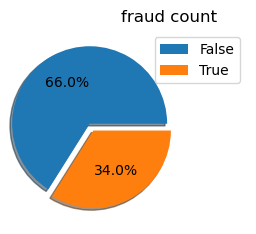

In [34]:
fig = df['fraud_flag'].value_counts().plot(kind="pie", autopct='%1.1f%%',
                                shadow=True, explode=[0.05, 0.05], 
                                legend=True,  ylabel='', labeldistance=None, 
                                title='df',figsize=(2, 3))
fig.set_xlim(0, 2)
fig.set_title('fraud count')
plt.show()

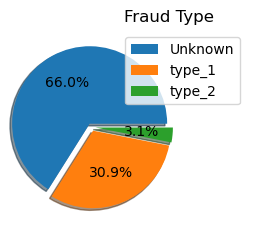

In [35]:
# Replace NaN values with a string representation (e.g., 'Unknown')
fraud = df.copy()
fraud['fraud_type'].fillna('Unknown', inplace=True)

# Calculate value counts and plot the pie chart
fig = fraud['fraud_type'].value_counts().plot(kind='pie', autopct='%1.1f%%',
                                           shadow=True, explode=[0.05, 0.05, 0.05], 
                                           legend=True, ylabel='', labeldistance=None, 
                                           title='Fraud Type', figsize=(2, 3))

fig.set_xlim(0, 2)
fig.set_title('Fraud Type')

plt.show()

When we predict the fraud type, we have very small amount of minority class.

<a id='Continuous_Numerical_Features'></a>
<h3 style="color:blue">2.2 Continuous Numerical Features</h3> 

### Continuous Numerical Features Distribution

In [36]:
continuous_num

['transactions_count',
 'orders_count',
 'payments_count',
 'fraud_score',
 'transaction_amount',
 'payment_method_type_card']

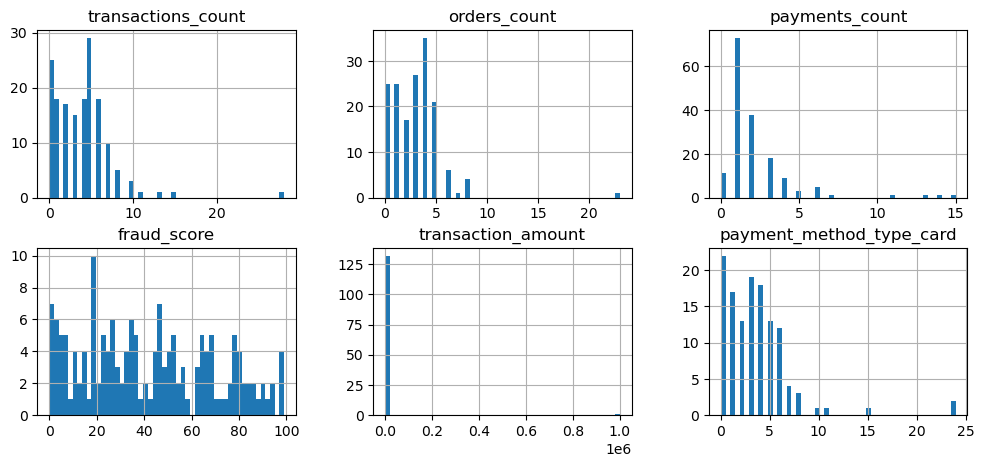

In [37]:
# Let's make a histogram to get familiar with the
# variable distribution.

fig, axs = plt.subplots(2, 3, figsize=(12, 5))
df[continuous_num].hist(bins=50,ax=axs)
plt.show();

### Distribution of continuous numeric features vs Fraud_flag or Fraud_type

In [38]:
# Delete the maximum transaction amount
max_transaction_amount = df['transaction_amount'].max()
transaction_amount = df[df['transaction_amount'] != max_transaction_amount]

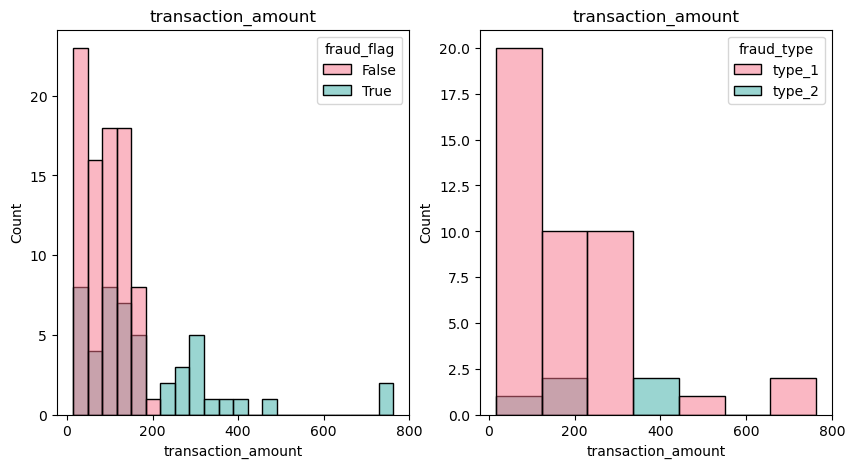

In [39]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

plt.subplot(1,2,1)
sns.histplot(x='transaction_amount',hue= 'fraud_flag', data=transaction_amount, palette = 'husl')
plt.title('transaction_amount')

plt.subplot(1,2,2)
sns.histplot(x='transaction_amount', hue= 'fraud_type', data=transaction_amount, palette = 'husl')
plt.title('transaction_amount')
plt.show();

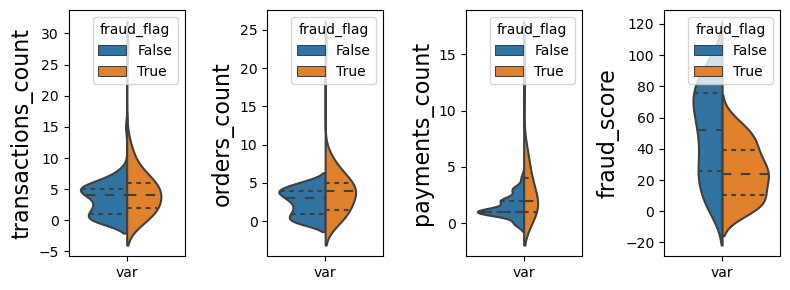

In [40]:
numdf = df.loc[:,('fraud_flag','transactions_count', 'orders_count', 'payments_count', 'fraud_score')]
numdf['var']='var'
fig, axes = plt.subplots(1,4,figsize = (8,3), dpi = 100)
for i,col in enumerate(['transactions_count', 'orders_count', 'payments_count', 'fraud_score']):
    c = i%4
    ax=sns.violinplot(x='var', y=col, data=numdf, hue='fraud_flag', split=True, inner='quart',ax=axes[c])
    ax.set(xlabel=None)
    ax.set_ylabel(f'{col}', fontsize=16)
    ax.tick_params(labelsize=10)
plt.tight_layout();
plt.show();

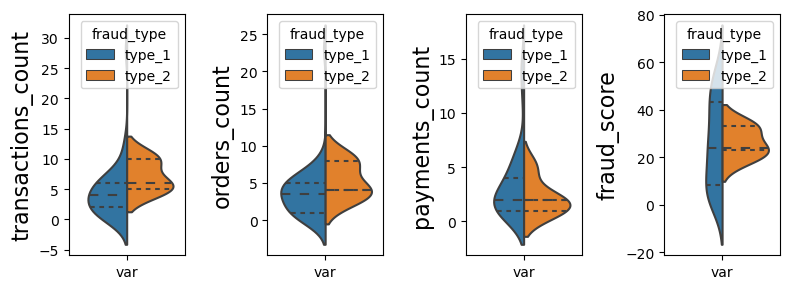

In [41]:
numdf = df.loc[:,('fraud_type','transactions_count', 'orders_count', 'payments_count', 'fraud_score')]
numdf['var']='var'
fig, axes = plt.subplots(1,4,figsize = (8,3), dpi = 100)
for i,col in enumerate(['transactions_count', 'orders_count', 'payments_count', 'fraud_score']):
    c = i%4
    ax=sns.violinplot(x='var', y=col, data=numdf, hue='fraud_type', split=True, inner='quart',ax=axes[c])
    ax.set(xlabel=None)
    ax.set_ylabel(f'{col}', fontsize=16)
    ax.tick_params(labelsize=10)
plt.tight_layout();
plt.show();

All continuous variables show variance vs Fraud_flag and Fraud_type

Using the fraud score to predict fraud is not accurate. This is because there are different types of fraud, and the fraud score alone may not capture all the necessary information to differentiate between them.

For example, in Type 1 fraud cases, the fraud score vary from low to high, indicating a wide range of fraudulent activities. On the other hand, Type 2 fraud cases may have a moderate level of fraud score, which is not be classified as high.

<a id='Discrete_Variable'></a>
<h3 style="color:blue">2.3 Discrete Variables</h3>

In [42]:
discrete_num

['transaction_failed',
 'payment_method_registration_failure',
 'payment_method_type_apple pay',
 'payment_method_type_bitcoin',
 'payment_method_type_paypal',
 'payment_method_provider_American Express',
 'payment_method_provider_Diners Club / Carte Blanche',
 'payment_method_provider_Discover',
 'payment_method_provider_JCB 15 digit',
 'payment_method_provider_JCB 16 digit',
 'payment_method_provider_Maestro',
 'payment_method_provider_Mastercard',
 'payment_method_provider_VISA 13 digit',
 'payment_method_provider_VISA 16 digit',
 'payment_method_provider_Voyager']

In [43]:
def plot_counts(df, category_col, target_col, length, height, fontsize, show_percentages=True, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(length, height))
        ax = fig.add_subplot(111)
    sns.countplot(x=category_col, hue=target_col, data=df, ax=ax)
    if show_percentages:
        total_counts = len(df)
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height / total_counts * 100:.1f}%', 
                        xy=(p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', xytext=(0, 5),
                        textcoords='offset points', fontsize=fontsize)

In [44]:
def plot_counts_2(df, category_col, target_col, length, height, fontsize, show_percentages=True, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(length, height))
        ax = fig.add_subplot(111)

    # Create a new column in the DataFrame to represent the combined categories
    df['combined_category'] = np.where(df[category_col] == 0, '0', 'positive_value')
    
    sns.countplot(x='combined_category', hue=target_col, data=df, ax=ax)
    
    if show_percentages:
        total_counts = len(df)
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height / total_counts * 100:.1f}%', 
                        xy=(p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', xytext=(0, 5),
                        textcoords='offset points', fontsize=fontsize)
    
    # Remove the temporary column from the DataFrame
    df.drop('combined_category', axis=1, inplace=True)
    
    # Remove the figure name
    ax.set_title('')
    # Remove x-axis label
    ax.set_xlabel('')

### transaction_failed and payment_method_registration_failure vs Fraud_flag or Fraud_type

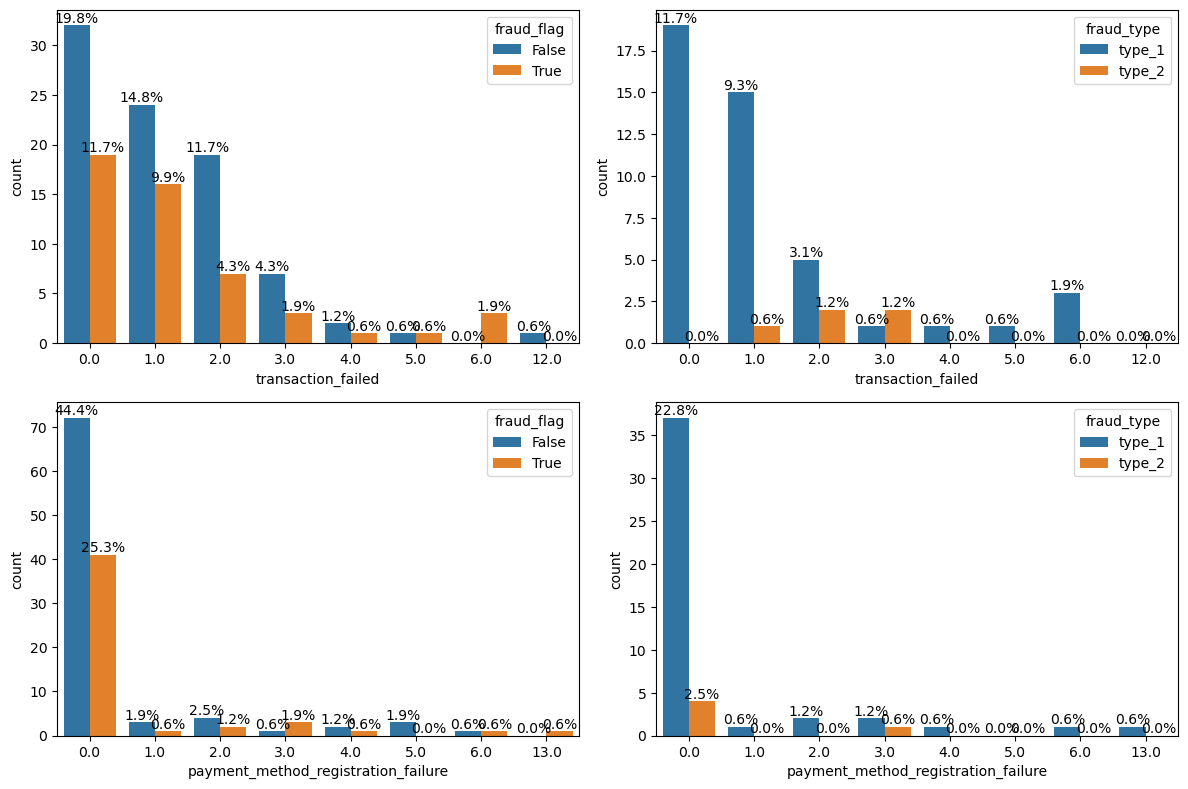

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

payment_types = [
    'transaction_failed',
    'payment_method_registration_failure'
]

for i, payment_type in enumerate(payment_types):
    plot_counts(df, payment_type, 'fraud_flag', 3, 3, 10, ax=axs[i, 0])
    plot_counts(df, payment_type, 'fraud_type', 3, 3, 10, ax=axs[i, 1])

plt.tight_layout()
plt.show();

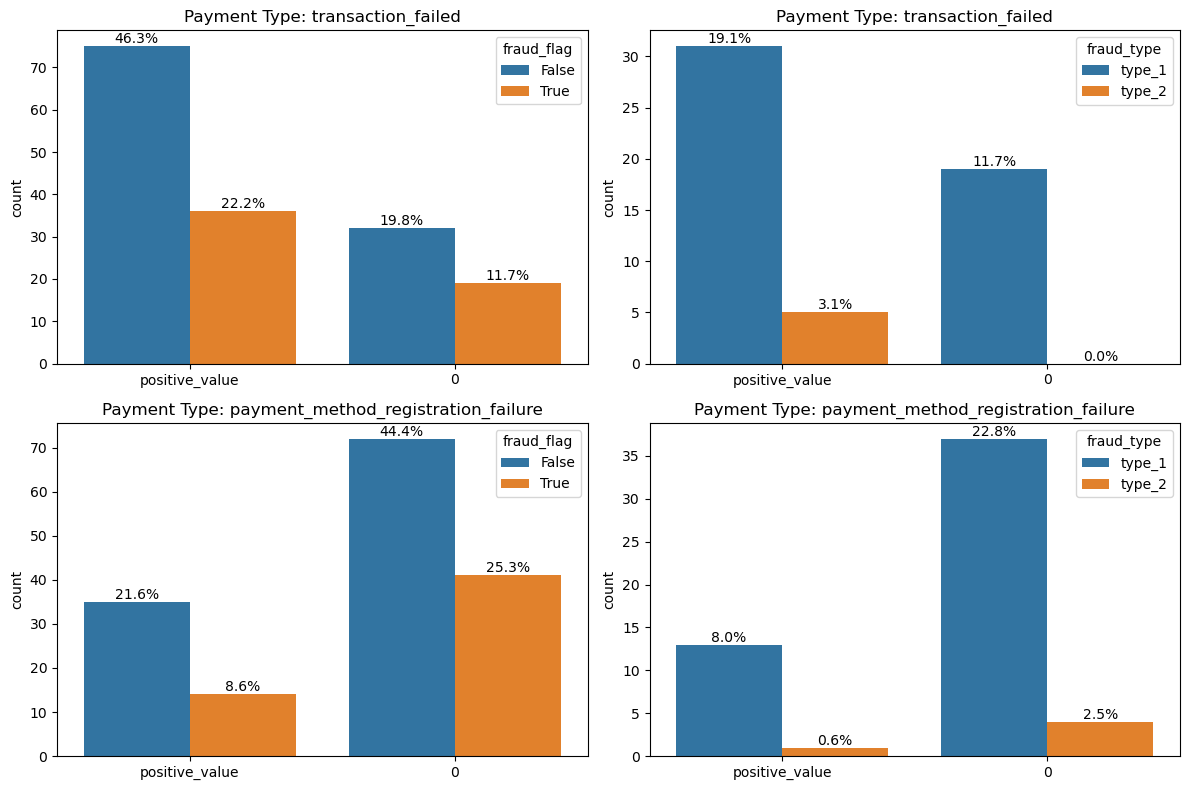

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

payment_types = [
    'transaction_failed',
    'payment_method_registration_failure'
]

for i, payment_type in enumerate(payment_types):
    ax1 = axs[i, 0]
    ax2 = axs[i, 1]
    
    plot_counts_2(df, payment_type, 'fraud_flag', 3, 3, 10, ax=ax1)
    plot_counts_2(df, payment_type, 'fraud_type', 3, 3, 10, ax=ax2)
    
    # Set the payment type as the title for each subplot
    ax1.set_title(f'Payment Type: {payment_type}')
    ax2.set_title(f'Payment Type: {payment_type}')

plt.tight_layout()
plt.show()

### payment_method_type vs Fraud_flag or Fraud_type

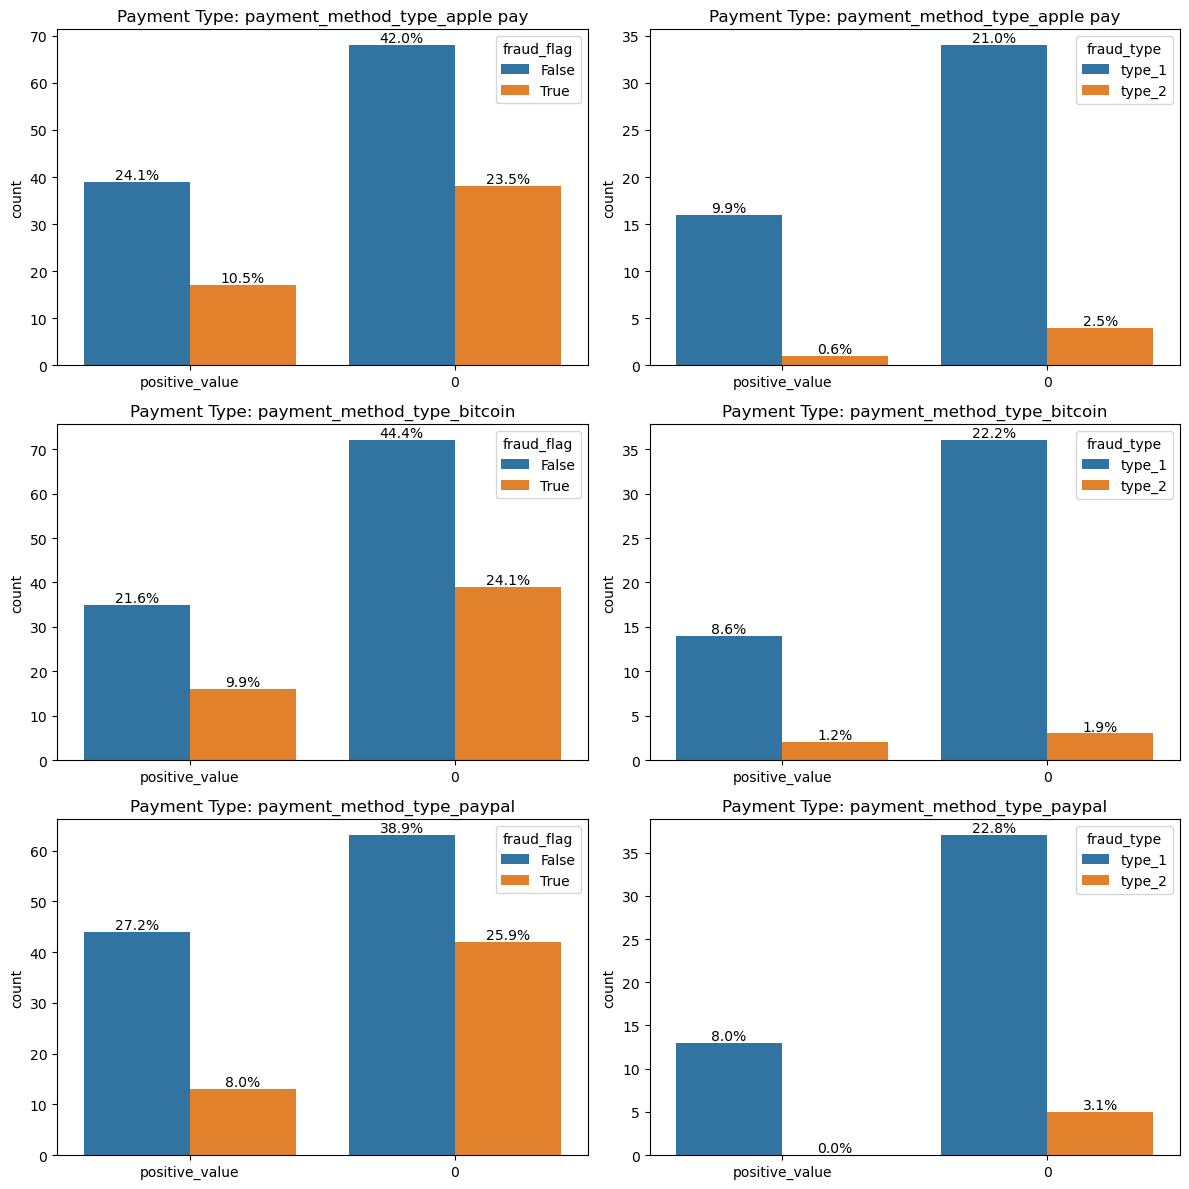

In [47]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

payment_types = [
    'payment_method_type_apple pay',
    'payment_method_type_bitcoin',
    'payment_method_type_paypal'
]

for i, payment_type in enumerate(payment_types):
    ax1 = axs[i, 0]
    ax2 = axs[i, 1]
    
    plot_counts_2(df, payment_type, 'fraud_flag', 3, 3, 10, ax=ax1)
    plot_counts_2(df, payment_type, 'fraud_type', 3, 3, 10, ax=ax2)
    
    # Set the payment type as the title for each subplot
    ax1.set_title(f'Payment Type: {payment_type}')
    ax2.set_title(f'Payment Type: {payment_type}')

plt.tight_layout()
plt.show()

payment_method_type show low variance with Fraud_flag or Fraud_type.

### payment_method_provider vs fraud_flag

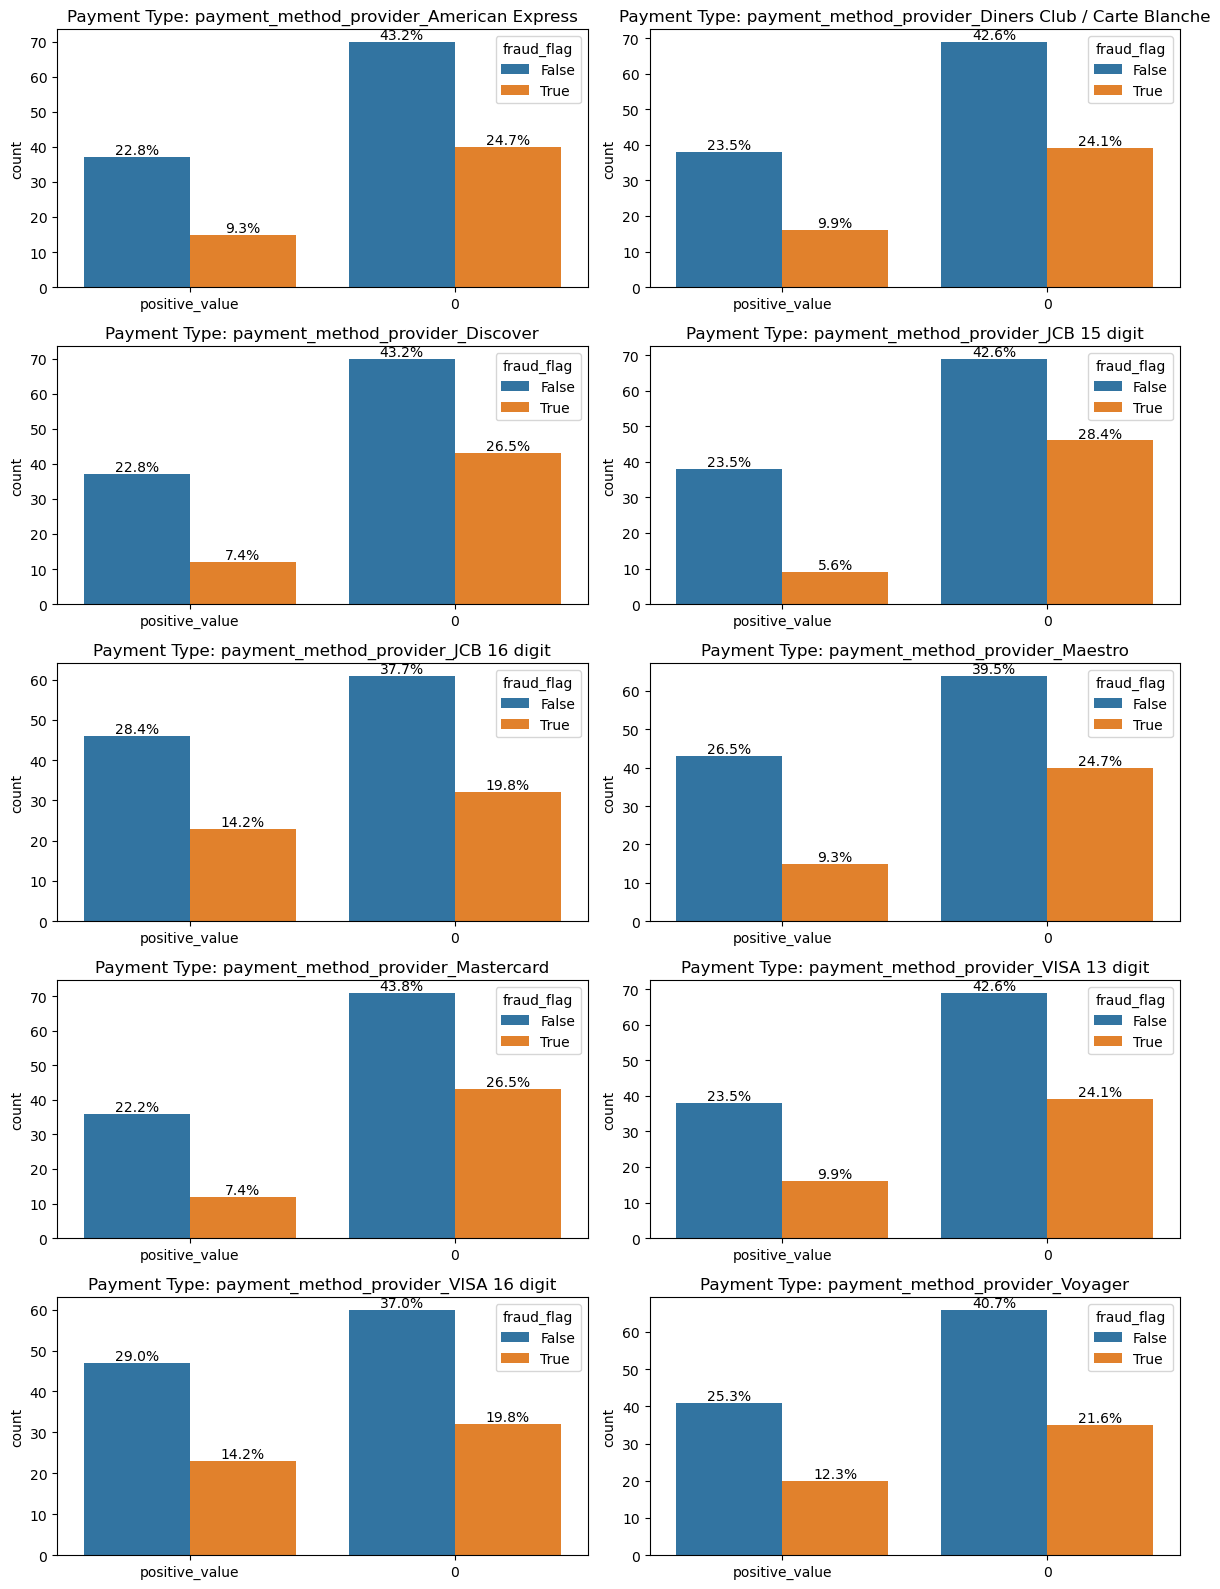

In [48]:
fig, axs = plt.subplots(5, 2, figsize=(12, 16))

providers = [
    'payment_method_provider_American Express',
    'payment_method_provider_Diners Club / Carte Blanche',
    'payment_method_provider_Discover',
    'payment_method_provider_JCB 15 digit',
    'payment_method_provider_JCB 16 digit',
    'payment_method_provider_Maestro',
    'payment_method_provider_Mastercard',
    'payment_method_provider_VISA 13 digit',
    'payment_method_provider_VISA 16 digit',
    'payment_method_provider_Voyager'
]

for i, provider in enumerate(providers):
    plot_counts_2(df, provider, 'fraud_flag', 3, 3, 10, ax=axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title(f'Payment Type: {provider}')  # Set the payment type as the title for each subplot

plt.tight_layout()
plt.show()

### payment_method_provider vs fraud_type

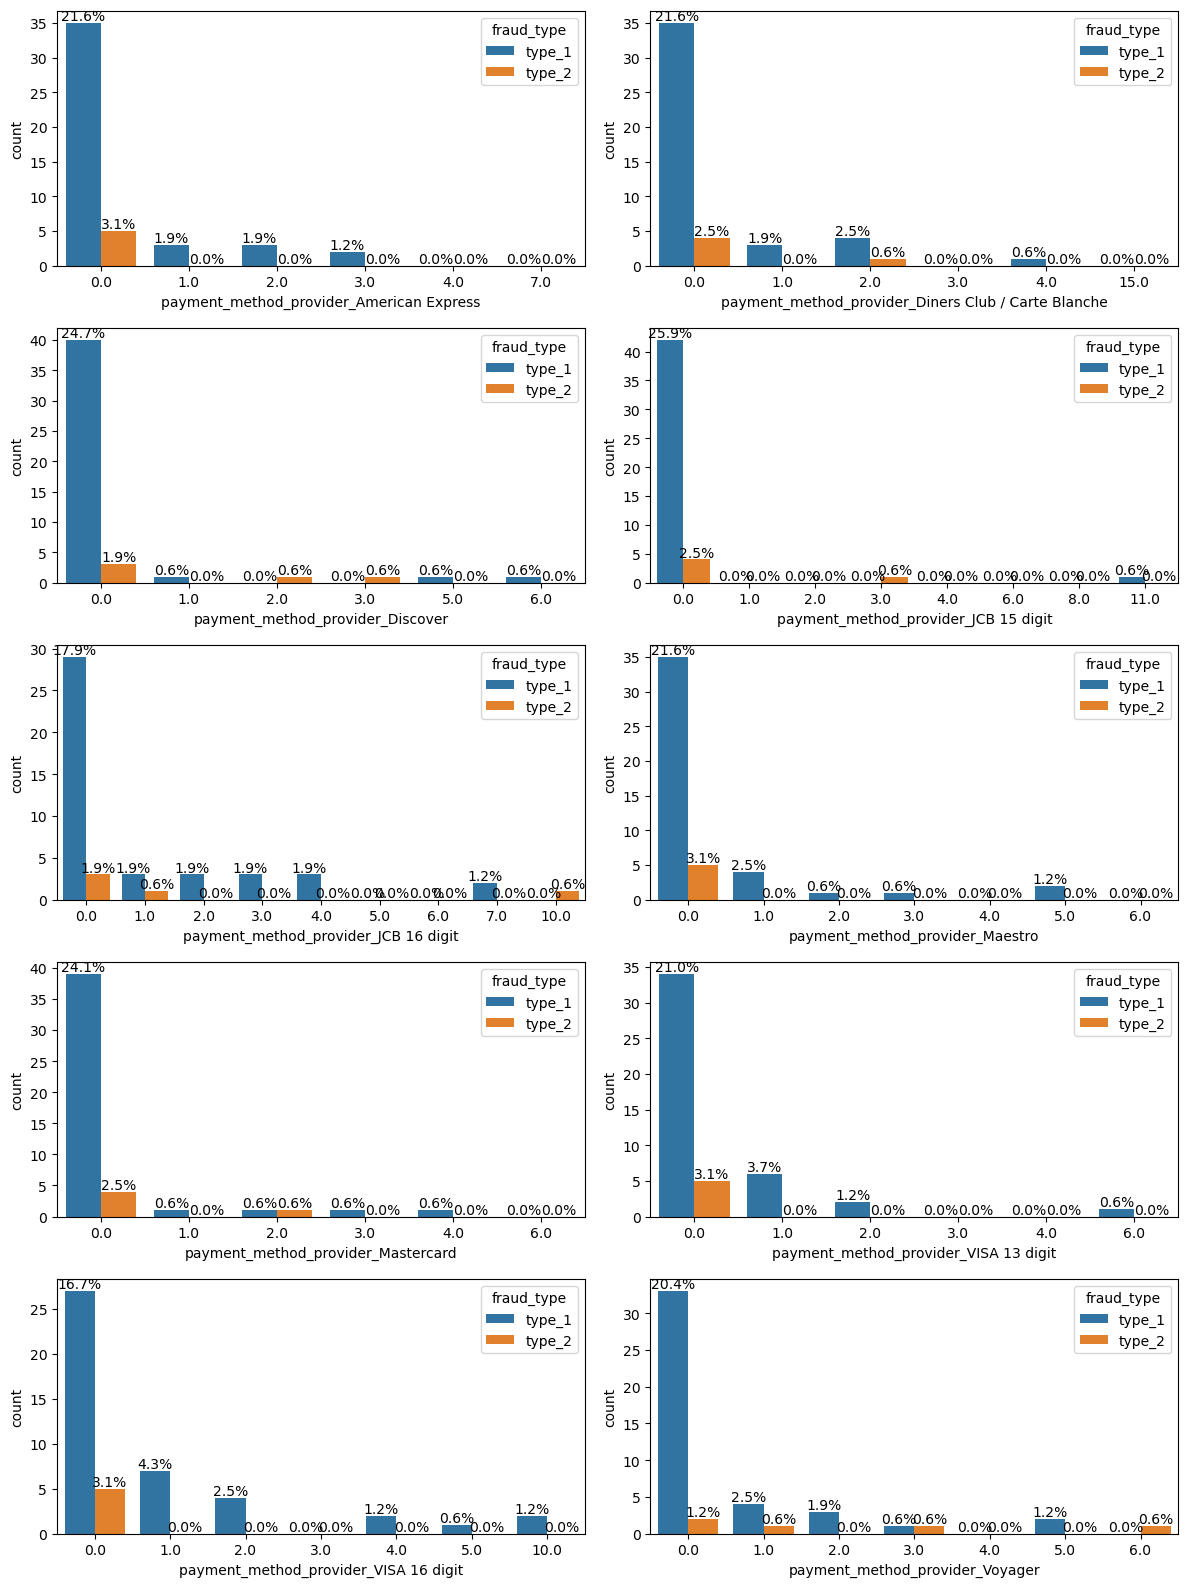

In [49]:
fig, axs = plt.subplots(5, 2, figsize=(12, 16))

providers = [
    'payment_method_provider_American Express',
    'payment_method_provider_Diners Club / Carte Blanche',
    'payment_method_provider_Discover',
    'payment_method_provider_JCB 15 digit',
    'payment_method_provider_JCB 16 digit',
    'payment_method_provider_Maestro',
    'payment_method_provider_Mastercard',
    'payment_method_provider_VISA 13 digit',
    'payment_method_provider_VISA 16 digit',
    'payment_method_provider_Voyager'
]

for i, provider in enumerate(providers):
    plot_counts(df, provider, 'fraud_type', 3, 3, 10, ax=axs[i//2, i%2])

plt.tight_layout()
plt.show()


<a id='Categorical_Variables'></a>
<h3 style="color:blue">2.4 Categorical Variables</h3

### customer_ip_address

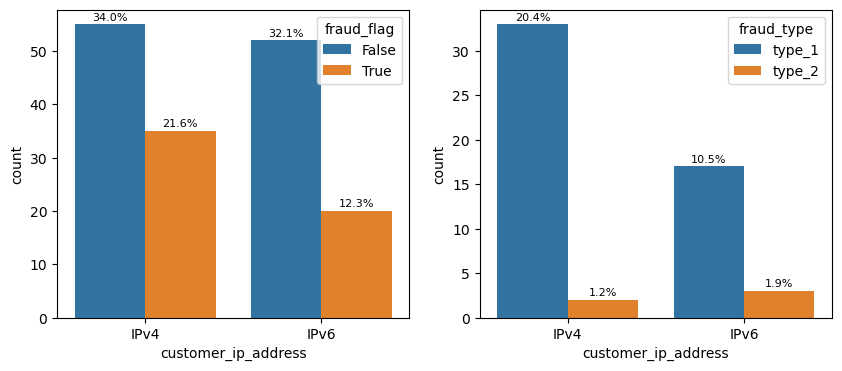

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

plot_counts(df, 'customer_ip_address', 'fraud_flag', 3,3,8, ax=axs[0])
plot_counts(df, 'customer_ip_address','fraud_type', 3,3,8, ax=axs[1])

plt.show();

### state

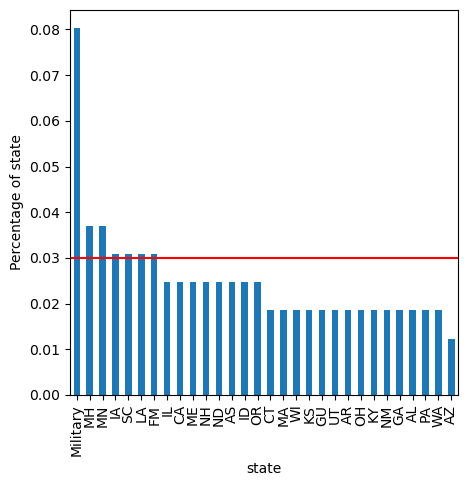

In [51]:
# The percentage of state per category.

temp_df = pd.Series(df['state'].value_counts() / len(df))

# Make plot with these percentages.
f, axes = plt.subplots(1,1, figsize=(5,5))
fig = temp_df.sort_values(ascending=False).head(30).plot.bar()
fig.set_xlabel('state')

# Add a line at 3 % to flag labels.
fig.axhline(y=0.03, color='red')
fig.set_ylabel('Percentage of state')
plt.show()

### state vs fraud_flag

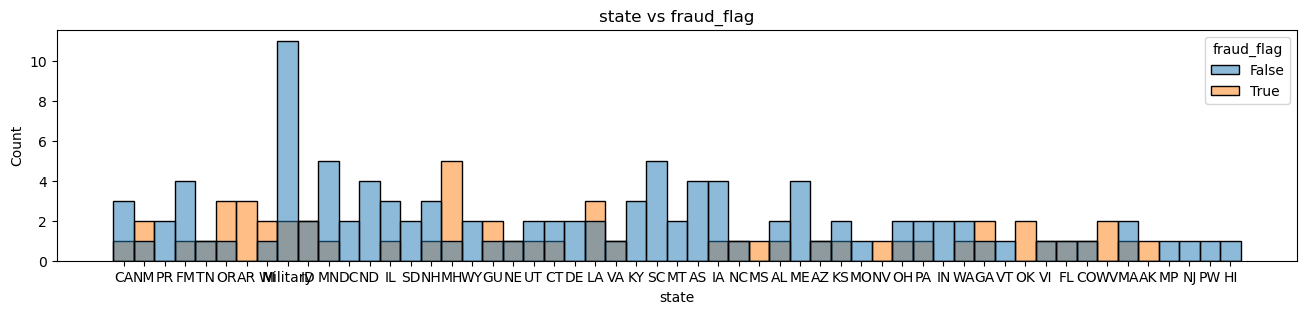

In [52]:
fig, ax = plt.subplots(figsize=(16,3))
sns.histplot(x='state', hue='fraud_flag', data=df)
plt.title('state vs fraud_flag')
plt.show();

PR, DC, ND, SD, WY, DE, KY, SC, MT, AS, ME, MO, IN, VT, MP, NJ, PW, HI are all not fraud

### state vs fraud_type

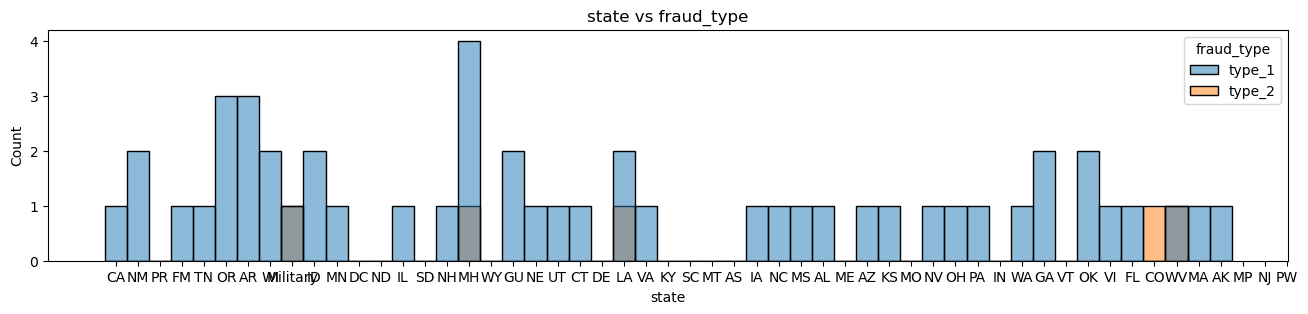

In [53]:
fig, ax = plt.subplots(figsize=(16,3))
sns.histplot(x='state', hue='fraud_type', data=df)
plt.title('state vs fraud_type')
plt.show();

military, MH, LA CO, WV are all type2 fraud.

<a id="Relationship_between_variables"></a>
<h3 style="color:blue">2.5 Relationship between variables</h3>

### Correlation between continuous cumeric features

In [54]:
continuous_num

['transactions_count',
 'orders_count',
 'payments_count',
 'fraud_score',
 'transaction_amount',
 'payment_method_type_card']

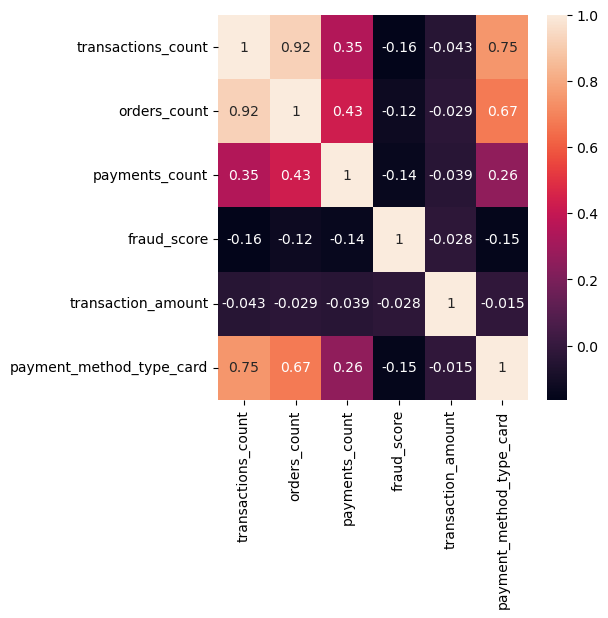

In [55]:
# fill the missing for numerical data
imp_mean = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
num_df = pd.DataFrame(imp_mean.fit_transform(df[continuous_num]))
num_df.columns = df[continuous_num].columns.tolist()

correlations = num_df.corr()
f, ax = plt.subplots(figsize = (5, 5))
sns.heatmap(correlations, annot = True)
plt.show();

payment_method_type_card has linera correlation with transactions_count, orders_count.

transactions_count and orders_count show strong correlation.

In [56]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df[continuous_num].columns.tolist()

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(num_df.values, i)
for i in range(len(num_df.columns))]
vif_data.sort_values(by='VIF', ascending=False)

,feature,VIF
0,transactions_count,19.252208
1,orders_count,18.032876
5,payment_method_type_card,3.634222
2,payments_count,2.196075
3,fraud_score,1.585022
4,transaction_amount,1.004643


Transactions_count show high multicollinearity with other variables.

Orders_count show high multicollinearity with other variables.

<a id="Relationship_between_target_and_variables"></a>
<h3 style="color:blue">2.5 Relationship between target and variables</h3>

### Correlation between fraud_flag and features

#### Relationship between a categorical variable and a continuous variable, you can use other statistical methods such as ANOVA (analysis of variance)

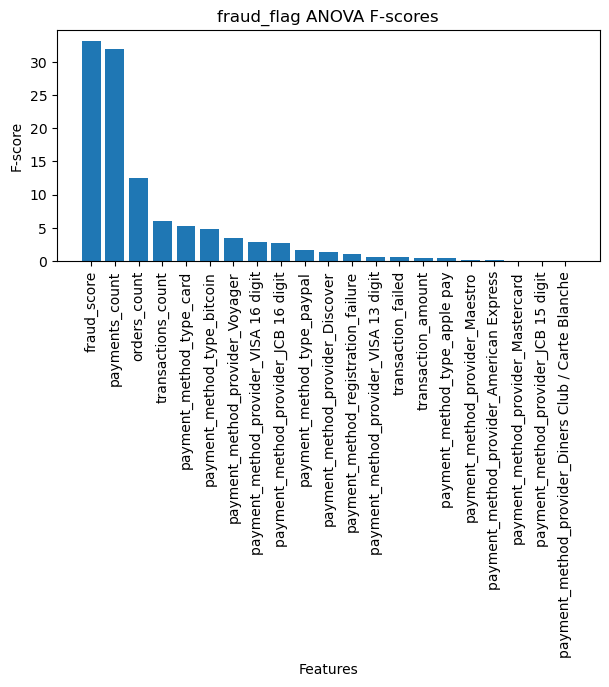

In [57]:
data = df.copy()
# target labbelEncoding
data['fraud_flag'] = LabelEncoder().fit_transform(data['fraud_flag'])

# Drop the target variable from the data
X = data.drop(['fraud_type', 'fraud_flag','state','customer_ip_address'], axis=1)
y = data['fraud_flag']

# Drop features with zero variance
#X = X.loc[:, X.var() > 0]

# Fill missing values with 0
imp = SimpleImputer(strategy='constant', fill_value=0)
X_filled = imp.fit_transform(X)

# Calculate ANOVA F-scores
f_scores, p_values = f_classif(X_filled, y)

# Create a dictionary to store the feature names and their corresponding F-scores
feature_scores = {feature: score for feature, score in zip(X.columns, f_scores)}

# Sort the feature scores in descending order
sorted_scores = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Extract the feature names and scores from the sorted list
features = [feature for feature, _ in sorted_scores]
scores = [score for _, score in sorted_scores]

# Plot histogram of feature scores
plt.figure(figsize=(7, 3))
plt.bar(features, scores)
plt.xlabel('Features')
plt.ylabel('F-score')
plt.title('fraud_flag ANOVA F-scores')
plt.xticks(rotation=90)
plt.show()

Fraud_flag has strong association with fraud score, payments_count, orders_count.

### Correlation between fraud_type and features

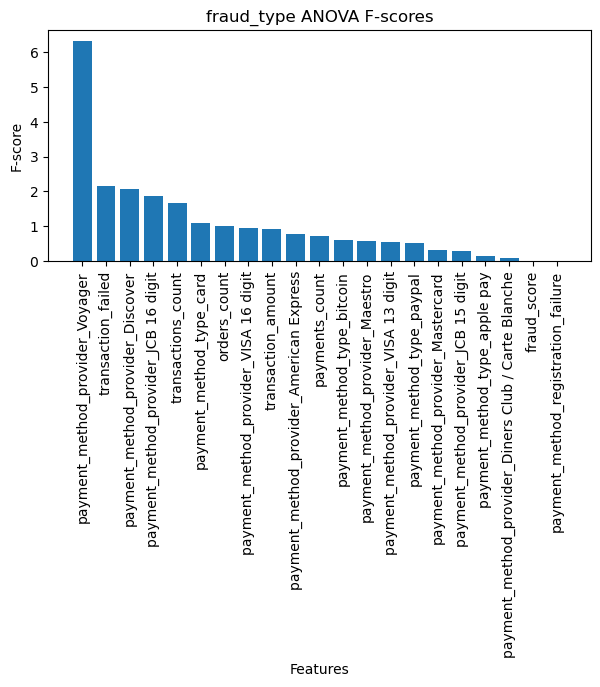

In [58]:
data = df.copy()
data = data[data['fraud_type'].notnull()]

X = data.drop(['fraud_type', 'fraud_flag','customer_ip_address','state'], axis=1)
y = data['fraud_type']

# Drop features with zero variance
#X = X.loc[:, X.var() > 0]

# Fill missing values with 0
imp = SimpleImputer(strategy='constant', fill_value=0)
X_filled = imp.fit_transform(X)

# Calculate ANOVA F-scores
f_scores, p_values = f_classif(X_filled, y)

# Create a dictionary to store the feature names and their corresponding F-scores
feature_scores = {feature: score for feature, score in zip(X.columns, f_scores)}

# Sort the feature scores in descending order
sorted_scores = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

# Extract the feature names and scores from the sorted list
features = [feature for feature, _ in sorted_scores]
scores = [score for _, score in sorted_scores]

# Plot histogram of feature scores
plt.figure(figsize=(7, 3))
plt.bar(features, scores)
plt.xlabel('Features')
plt.ylabel('F-score')
plt.title('fraud_type ANOVA F-scores')
plt.xticks(rotation=90)
plt.show()


Fraud_type has strong association with payment provider voyager.

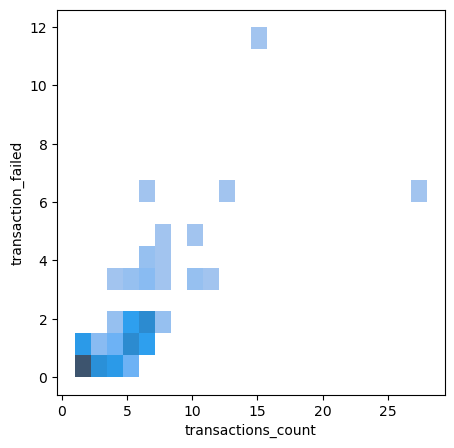

In [59]:
# Let's see the transactions_count vs. transaction_failed
plt.figure(figsize=(5, 5))
sns.histplot(x = 'transactions_count', y = 'transaction_failed', data = df)
plt.show();

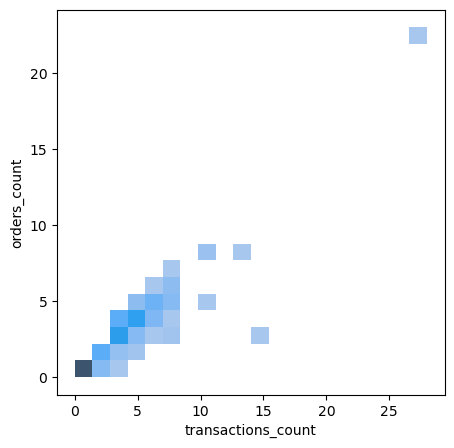

In [60]:
plt.figure(figsize=(5, 5))
sns.histplot(x = 'transactions_count', y = 'orders_count', data = df)
plt.show();

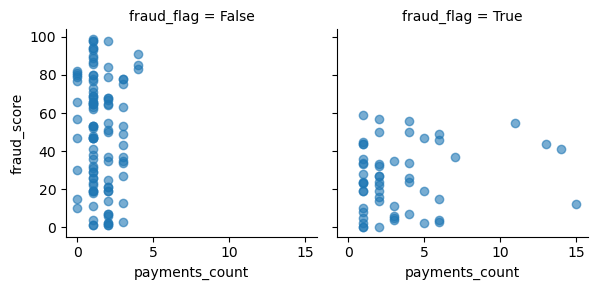

In [61]:
sns.FacetGrid(df, col = "fraud_flag").map(plt.scatter, "payments_count", 'fraud_score', alpha =0.6).add_legend()
plt.show();

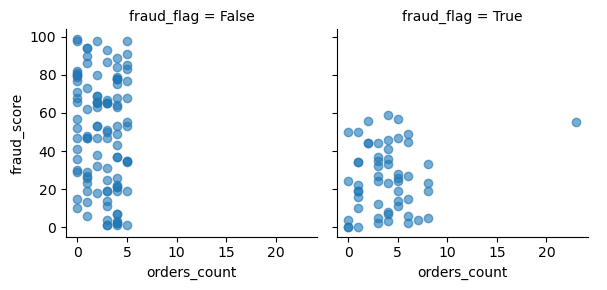

In [62]:
sns.FacetGrid(df, col = "fraud_flag").map(plt.scatter, "orders_count", 'fraud_score', alpha =0.6).add_legend()
plt.show();

### Phi-K test is used to measure the association between two categorical variables.

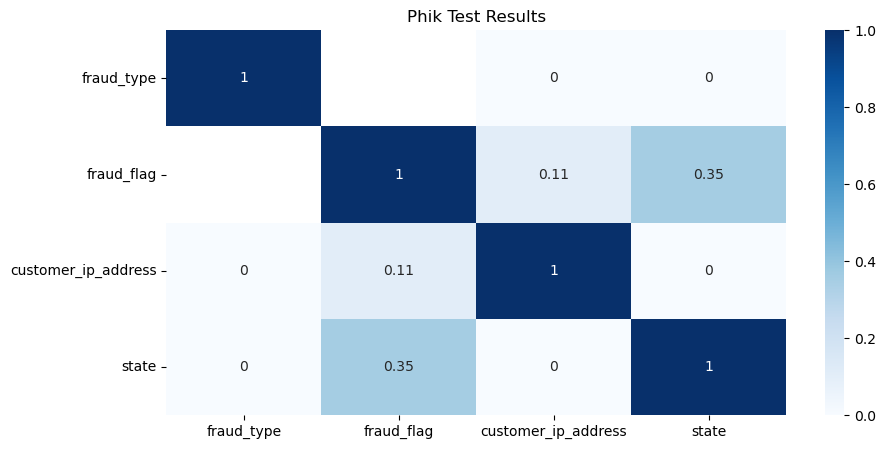

In [63]:
result = df[['fraud_type', 'fraud_flag','customer_ip_address','state']].phik_matrix()

fig = plt.figure(figsize=(10,5))
sns.heatmap(result, cmap='Blues', annot=True)
plt.title('Phik Test Results')
plt.show()

<a id="EDA_Summary"></a>
<h3 style="color:blue">2.6 EDA Summary</h3>

<br>
1. Data preprocessing
    
    - clean duplicated customer_email values
    
    - from transactions table, create transaction_amount, transaction_failed, payment_method_registration_failure, merge on customer table
    
    - one-hot encoding on 'payment_method_type', 'payment_method_provider', merge on the customer table
    
    - State is extracted from Customer address
    
    - Customer ip address is categorized as IPv4 and IPv6.
    
<br>    
2. Data Visualization 

    - Fraud_flag:66% False, 34% True
   
    - Fraud_type:66% unknown, 30.9% type_1, 3.1% type_2 (too many nan)

    - Continuous numeric variables: All have high variation with Fraud_flag and Fraud_type.
   
    - Discrete numeric variables: transaction_failed, payment_method_registration_failure, payment_method_provider have some variation with Fraud_flag and Fraud_type.
    
    - payment_method_type has very low variation.
    
    - PR, DC, ND, SD, WY, DE, KY, SC, MT, AS, ME, MO, IN, VT, MP, NJ, PW, HI are all not fraud.
    
    - military, MH, LA CO, WV are all type2 fraud.
   
<br>
3. Linear correlation

    - payment_method_type_card has linear correlation with transactions_count, orders_count.

    - transactions_count and orders_count show strong linear correlation.

<br>
4. Relation between target and variables

    - Fraud_flag has strong association with fraud score, payments_count, orders_count.

    - Fraud_type has strong association with payment provider voyager.

<a id='Fraud_flag_Model'></a>
<h1 style="background-color:#fbcc54;font-family:monospace;font-size:200%;text-align:center">3. Fraud_flag Model </h1>

#### Model Evaluator

In [64]:
class ModelEvaluatorThreshold:
    def __init__(self, model, X_train, X_test, y_train, y_test):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
    def evaluate(self, title):
        y_train_proba = self.model.predict_proba(self.X_train)
        y_test_proba = self.model.predict_proba(self.X_test)

        y_test_pred = np.zeros(len(y_test_proba), dtype=int)
        y_test_pred[y_test_proba[:,0]<=0.5] = 1

        thresholds = np.linspace(0.01,0.9,10)
        # thresholds = np.linspace(0, 1, 10)

        precision = []
        recall = []
        f1 = []

        for t in thresholds:
            y_test_pred = np.zeros(len(y_test_proba), dtype=int)
            y_test_pred[y_test_proba[:,1]>t] = 1
            # y_test_pred = (y_test_proba[:, 1] > t).astype(int)
            precision.append(precision_score(self.y_test, y_test_pred))
            recall.append(recall_score(self.y_test, y_test_pred))
            f1.append(f1_score(self.y_test, y_test_pred))

        plt.plot(thresholds, precision, label = "precision")
        plt.plot(thresholds, recall, label = "recall")
        plt.plot(thresholds, f1, label = "f1_score")
        plt.xlabel('Thresholds')
        plt.ylabel('Scores')
        plt.title(title)
        plt.ylim([0,1])
        plt.legend()
        plt.show()

In [65]:
class ConfusionMatrixVisualizer:
    def __init__(self, model, X_test, y_test, title='Confusion Matrix'):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.title = title
    
    def generate_confusion_matrix(self):
        y_pred = self.model.predict(self.X_test)
        cf_matrix = confusion_matrix(self.y_test, y_pred)
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
        plt.title(self.title)
        plt.show()

<a id="Train/Test_data_ready_for_modeling"></a>
<h3 style="color:blue">3.1 Train/Test data ready for modeling</h3>

Train Dataset: Used to fit the machine learning model.<br>
Test Dataset: Used to evaluate the fit machine learning model.

In [66]:

X = df.drop(['fraud_type','fraud_flag'], axis=1)
y = df['fraud_flag']
le = preprocessing.LabelEncoder()
label_encoder = le.fit(y)
y = label_encoder.transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=5)

<a id="Categorical_encoders_tuning_on_state"></a>
<h3 style="color:blue">3.2 Categorical encoders tuning on state</h3>


In [67]:
categorical

['customer_ip_address', 'state']

In [68]:
numeric_features = X.columns.drop(['customer_ip_address', 'state'])

In [69]:
# List of encoders
encoder_list = [
    ce.backward_difference.BackwardDifferenceEncoder,
    ce.basen.BaseNEncoder,
    ce.binary.BinaryEncoder,
    ce.cat_boost.CatBoostEncoder,
    ce.hashing.HashingEncoder,
    ce.helmert.HelmertEncoder,
    ce.james_stein.JamesSteinEncoder,
    ce.one_hot.OneHotEncoder,
    ce.leave_one_out.LeaveOneOutEncoder,
    ce.m_estimate.MEstimateEncoder,
    ce.ordinal.OrdinalEncoder,
    ce.sum_coding.SumEncoder,
    ce.target_encoder.TargetEncoder,
    ce.woe.WOEEncoder
]

for encoder in encoder_list:
    # Preprocessor pipeline
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=-1))])
    state_transformer = Pipeline(steps=[('woe', encoder())])
    binary_transformer = Pipeline(steps=[('ordinal', OneHotEncoder())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', state_transformer, ['state']),
            ('bin', binary_transformer, ['customer_ip_address'])
        ]
    )

    # Full pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=500, random_state=5))])

    # Perform cross-validation
    cv_scores = cross_val_score(pipe, X, y, scoring='f1_macro', cv=5)

    print(encoder)
    print("Cross-Validation F1 Score: ", cv_scores.mean())

<class 'category_encoders.backward_difference.BackwardDifferenceEncoder'>
Cross-Validation F1 Score:  0.7402887554887053
<class 'category_encoders.basen.BaseNEncoder'>
Cross-Validation F1 Score:  0.7457895231457814
<class 'category_encoders.binary.BinaryEncoder'>
Cross-Validation F1 Score:  0.7457895231457814
<class 'category_encoders.cat_boost.CatBoostEncoder'>
Cross-Validation F1 Score:  0.7186252364526537
<class 'category_encoders.hashing.HashingEncoder'>
Cross-Validation F1 Score:  0.7328576085110664
<class 'category_encoders.helmert.HelmertEncoder'>
Cross-Validation F1 Score:  0.7449724784932255
<class 'category_encoders.james_stein.JamesSteinEncoder'>
Cross-Validation F1 Score:  0.7051549562898136
<class 'category_encoders.one_hot.OneHotEncoder'>
Cross-Validation F1 Score:  0.7276360662842211
<class 'category_encoders.leave_one_out.LeaveOneOutEncoder'>
Cross-Validation F1 Score:  0.7183590564025346
<class 'category_encoders.m_estimate.MEstimateEncoder'>
Cross-Validation F1 Score:

#### choose woe.WOEEncoder() for now, with high Cross-Validation F1 Score

<a id='Feature_Selection'></a>
<h3 style="color:blue">3.3 Feature Selection</h3>

### Missing data imputation 

In [70]:
# numerical

X_train.select_dtypes(exclude='O').isnull().mean()

transactions_count                                     0.000000
orders_count                                           0.000000
payments_count                                         0.000000
fraud_score                                            0.000000
transaction_amount                                     0.170543
transaction_failed                                     0.155039
payment_method_registration_failure                    0.155039
payment_method_type_apple pay                          0.224806
payment_method_type_bitcoin                            0.224806
payment_method_type_card                               0.224806
payment_method_type_paypal                             0.224806
payment_method_provider_American Express               0.224806
payment_method_provider_Diners Club / Carte Blanche    0.224806
payment_method_provider_Discover                       0.224806
payment_method_provider_JCB 15 digit                   0.224806
payment_method_provider_JCB 16 digit    

#### Imputation methods I will perform: Numerical--arbitrary value imputation

<a id='RandomForest_Predict_Fraud_flag'></a>
<h3 style="color:blue">3.4 RandomForest Predict Fraud_flag</h3>

### Use feature_importances to select features

In [71]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1))
])

state_transformer = Pipeline(steps=[('woe', ce.woe.WOEEncoder())])

binary_transformer = Pipeline(steps=[('ordinal', ce.ordinal.OrdinalEncoder())])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', state_transformer, ['state']),
    ('bin', binary_transformer, ['customer_ip_address'])
])

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=5))
])

pipe.fit(X_train, y_train)

importance_scores = pipe.named_steps['classifier'].feature_importances_

sorted_scores = sorted(zip(importance_scores, X_train.columns), reverse=True)

k = 10
selected_features = [feature for (_, feature) in sorted_scores[:k]]

In [72]:
selected_features

['payment_method_provider_Voyager',
 'payments_count',
 'fraud_score',
 'orders_count',
 'transactions_count',
 'customer_ip_address',
 'payment_method_type_bitcoin',
 'payment_method_provider_VISA 13 digit',
 'state',
 'payment_method_type_card']

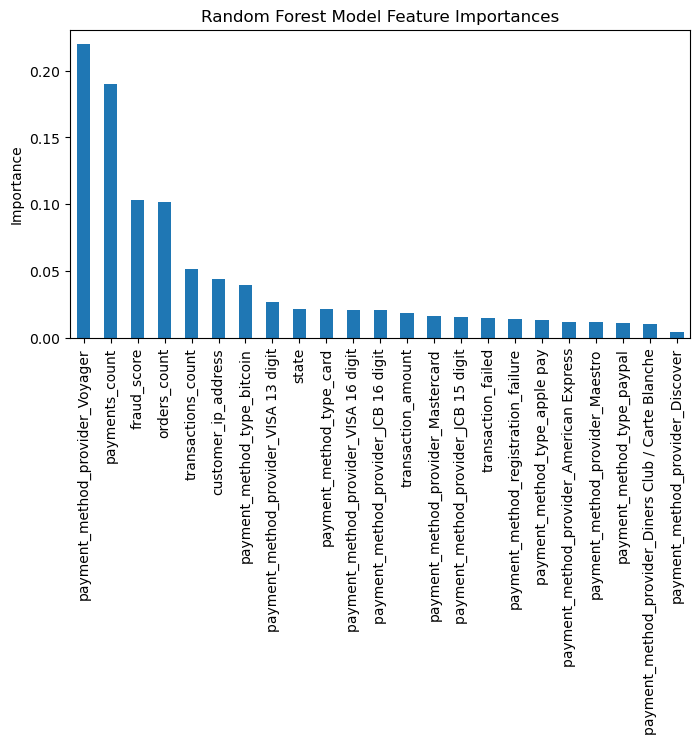

In [73]:
# Create a pandas Series with feature importances
fi = pd.Series(importance_scores, index=X_train.columns)

# Sort the series by importance and plot
fi.sort_values(ascending=False).plot.bar(figsize=(8, 4))
plt.ylabel('Importance')
plt.title('Random Forest Model Feature Importances')
plt.show()

### Use permutation importances to select features

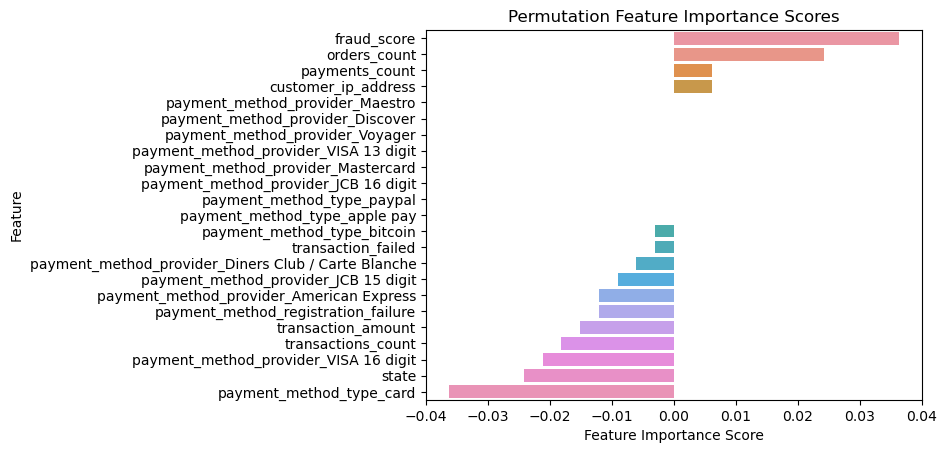

In [74]:
from sklearn.inspection import permutation_importance
r = permutation_importance(pipe, X_test, y_test,
                           n_repeats=10,
                           random_state=0)
perm = pd.DataFrame(columns=['AVG_Importance'], index=[i for i in X_train.columns])
perm['AVG_Importance'] = r.importances_mean
# Sort the feature importance scores in descending order
perm = perm.sort_values(by='AVG_Importance', ascending=False)
# Create a bar plot of the feature importance scores
sns.barplot(x=perm['AVG_Importance'], y=perm.index)

# Add labels and title
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance Scores')
plt.show()

In [75]:
X_train_ = X_train[selected_features]

X_test_ = X_test[selected_features]


In [76]:
selected_numeric_features = [feature for feature in selected_features if feature not in ['state', 'customer_ip_address']]

numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-1))])
    
state_transformer = Pipeline(steps=[('woe', ce.woe.WOEEncoder())])
    
binary_transformer = Pipeline(steps=[('ordinal', ce.ordinal.OrdinalEncoder())])
    
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, selected_numeric_features),
        ('cat', state_transformer, ['state']),
        ('bin', binary_transformer, ['customer_ip_address'])
])
    
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(class_weight='balanced', random_state=5))])

param_grid = {
    'classifier__bootstrap': [True, False],
    'classifier__max_depth': [10, 20, 30, 40, 50, 60, 80],
    'classifier__min_samples_leaf': [6, 8, 10, 12, 14],
    'classifier__min_samples_split': [2, 5, 10, 15, 20, 25],
    'classifier__n_estimators': [100, 200, 300, 400]
}

# Set up the search
search_rf = RandomizedSearchCV(
    pipe_rf,  # The model
    param_grid,  # Hyperparameter space
    scoring='average_precision',  # Metric to optimize
    cv=5,  # Number of cross-validation folds
    n_iter=5,  # Number of parameter settings to sample
    random_state=5,  # Random seed for reproducibility
    refit=True,  # Fit the model with best hyperparameters to the entire training set after the search
)

# Find the best hyperparameters
search_rf.fit(X_train_, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=-1,
                                                                                                              strategy='constant'))]),
                                                                               ['payment_method_provider_Voyager',
                                                                                'payments_count',
                                                                                'fraud_score',
                                                                                'orders_count',
                                                                                'transactions_count',
                                                                                'payment_method_type_bitcoin',
                                                                                'payment_method_provider_VISA '
                                                                                '13 '...
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=5))]),
                   n_iter=5,
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__max_depth': [10, 20, 30,
                                                                  40, 50, 60,
                                                                  80],
                                        'classifier__min_samples_leaf': [6, 8,
                                                                         10, 12,
                                                                         14],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10,
                                                                          15,
                                                                          20,
                                                                          25],
                                        'classifier__n_estimators': [100, 200,
                                                                     300,
                                                                     400]},
                   random_state=5, scoring='average_precision')

In [77]:
# best hyperparameters
search_rf.best_params_

{'classifier__n_estimators': 300,
 'classifier__min_samples_split': 15,
 'classifier__min_samples_leaf': 10,
 'classifier__max_depth': 30,
 'classifier__bootstrap': False}

In [78]:
X_train_preds_rf = search_rf.predict_proba(X_train_)[:,1]
X_test_preds_rf = search_rf.predict_proba(X_test_)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds_rf))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds_rf))

Train roc_auc:  0.9748663101604278
Test roc_auc:  0.8760330578512396


#### RandomForestClassifier has overfitting, we will try Xgboost with regularization next.

In [79]:
y_test_pred_rf = search_rf.predict(X_test_)
y_train_pred_rf = search_rf.predict(X_train_)

print('report for random forest training set')
print("====================================")
print(classification_report(y_train, y_train_pred_rf))
print('report for random forest testing set')
print("====================================")
print(classification_report(y_test, y_test_pred_rf))

report for random forest training set
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        85
           1       0.82      0.95      0.88        44

    accuracy                           0.91       129
   macro avg       0.90      0.92      0.91       129
weighted avg       0.92      0.91      0.92       129

report for random forest testing set
              precision    recall  f1-score   support

           0       0.89      0.77      0.83        22
           1       0.64      0.82      0.72        11

    accuracy                           0.79        33
   macro avg       0.77      0.80      0.77        33
weighted avg       0.81      0.79      0.79        33



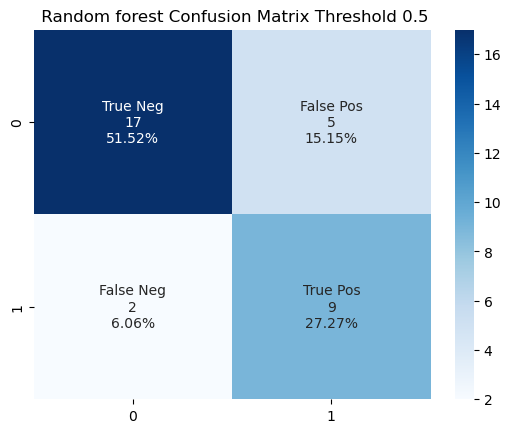

In [80]:
cmv = ConfusionMatrixVisualizer(search_rf, X_test_, y_test, title=' Random forest Confusion Matrix Threshold 0.5')
cmv.generate_confusion_matrix()

### Threshold optimization methods

C:\Users\xzhu5\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


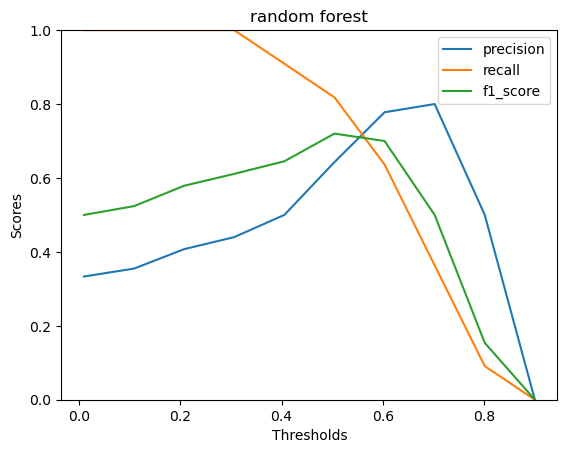

In [81]:
model_evaluator = ModelEvaluatorThreshold(search_rf, X_train_, X_test_, y_train, y_test)
model_evaluator.evaluate('random forest')

In [82]:
y_pred_opt_0 = (search_rf.predict_proba(X_test_)[:, 1] > 0.58).astype('float')
confusion_matrix(y_test, y_pred_opt_0)

array([[20,  2],
       [ 4,  7]], dtype=int64)

From the fig we see that precision increases with the increasing of threshold, recall decreases with the increasing of threshold.

At threshold =0.58, both presicion and recall are relative high.

Out of all 33 customers, the classifier predicted 8 positive, 7 are correct, there are 4 fraud were not predicted.

In [83]:
precision = precision_score(y_test, y_pred_opt_0)
recall = recall_score(y_test, y_pred_opt_0)

print(f"Precision at threshold {0.58}: {precision}")
print(f"Recall at threshold {0.58}: {recall}")

Precision at threshold 0.58: 0.7777777777777778
Recall at threshold 0.58: 0.6363636363636364


<a id='XGBoost_Predict_Fraud_flag'></a>
<h3 style="color:blue">3.5 XGBoost Predict Fraud_flag</h3>

In [84]:
pipe_2 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(seed=0, random_state=5, n_jobs=-1))])
param_grid = { 
    # deal imbalanced data 
    'classifier__scale_pos_weight':[1, 10, 25, 50, 75, 99, 100, 1000],
    'classifier__max_depth': [2, 4, 6, 8, 10, 15, 20, 30, 40],
    # Percentage of columns to be randomly samples for each tree.
    "classifier__colsample_bytree": [ 0.1, 0.2, 0.3, 0.5 , 0.8, 1.0],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "classifier__reg_alpha": [0, 0.5, 1, 5, 6, 7, 8],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "classifier__reg_lambda": [0, 0.5, 1, 5],
    "classifier__learning_rate": [0.005, 0.01, 0.03, 0.1]
    }

# set up the search
search_xgb = RandomizedSearchCV(
    pipe_2, # the model
    param_grid, # hyperparam space
    scoring='average_precision', # metric to optimize
    cv=5, # 5 would be better as the dataset is quite small
    n_iter = 5, # I do 5 to speed things up, but for randomized search 60 has been shown to find the optimal hyperparameters
    random_state=5, # reproducibility
    refit=True, # this fits the model with the best hyperparams to the entire training set after the hyperparam search
)

# find best hyperparameters
search_xgb.fit(X_train_, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=-1,
                                                                                                              strategy='constant'))]),
                                                                               ['payment_method_provider_Voyager',
                                                                                'payments_count',
                                                                                'fraud_score',
                                                                                'orders_count',
                                                                                'transactions_count',
                                                                                'payment_method_type_bitcoin',
                                                                                'payment_method_provider_VISA '
                                                                                '13 '...
                   param_distributions={'classifier__colsample_bytree': [0.1,
                                                                         0.2,
                                                                         0.3,
                                                                         0.5,
                                                                         0.8,
                                                                         1.0],
                                        'classifier__learning_rate': [0.005,
                                                                      0.01,
                                                                      0.03,
                                                                      0.1],
                                        'classifier__max_depth': [2, 4, 6, 8,
                                                                  10, 15, 20,
                                                                  30, 40],
                                        'classifier__reg_alpha': [0, 0.5, 1, 5,
                                                                  6, 7, 8],
                                        'classifier__reg_lambda': [0, 0.5, 1,
                                                                   5],
                                        'classifier__scale_pos_weight': [1, 10,
                                                                         25, 50,
                                                                         75, 99,
                                                                         100,
                                                                         1000]},
                   random_state=5, scoring='average_precision')

In [85]:
# best hyperparameters
search_xgb.best_params_

{'classifier__scale_pos_weight': 100,
 'classifier__reg_lambda': 0.5,
 'classifier__reg_alpha': 0.5,
 'classifier__max_depth': 6,
 'classifier__learning_rate': 0.01,
 'classifier__colsample_bytree': 0.3}

In [86]:
X_train_preds_xgb = search_xgb.predict_proba(X_train_)[:,1]
X_test_preds_xgb = search_xgb.predict_proba(X_test_)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds_xgb))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds_xgb))

Train roc_auc:  0.9213903743315508
Test roc_auc:  0.7107438016528925


In [87]:
y_test_pred_xgb = search_xgb.predict(X_test_)
y_train_pred_xgb = search_xgb.predict(X_train_)

print('report for training set')
print("====================================")
print(classification_report(y_train, y_train_pred_xgb))
print('report for testing set')
print("====================================")
print(classification_report(y_test, y_test_pred_xgb))

report for training set
              precision    recall  f1-score   support

           0       1.00      0.26      0.41        85
           1       0.41      1.00      0.58        44

    accuracy                           0.51       129
   macro avg       0.71      0.63      0.50       129
weighted avg       0.80      0.51      0.47       129

report for testing set
              precision    recall  f1-score   support

           0       1.00      0.09      0.17        22
           1       0.35      1.00      0.52        11

    accuracy                           0.39        33
   macro avg       0.68      0.55      0.35        33
weighted avg       0.78      0.39      0.29        33



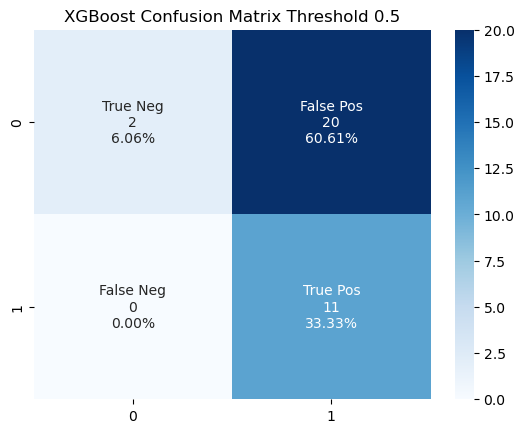

In [88]:
cmv = ConfusionMatrixVisualizer(search_xgb, X_test_, y_test, title='XGBoost Confusion Matrix Threshold 0.5')
cmv.generate_confusion_matrix()

### Threshold optimization

C:\Users\xzhu5\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


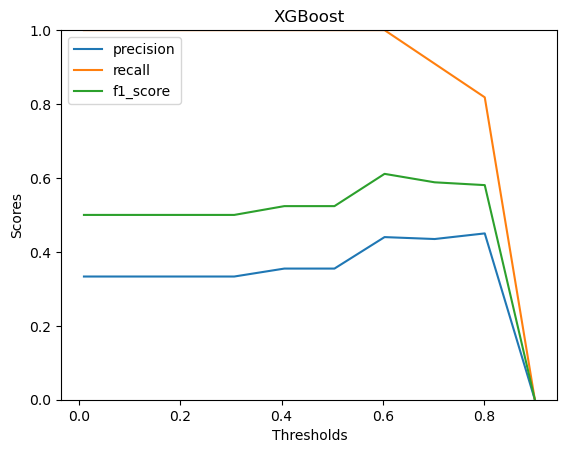

In [89]:
model_evaluator = ModelEvaluatorThreshold(search_xgb, X_train_, X_test_, y_train, y_test)
model_evaluator.evaluate('XGBoost')

In [90]:
y_pred_opt_0 = (search_xgb.predict_proba(X_test_)[:, 1] > 0.72).astype('float')
confusion_matrix(y_test, y_pred_opt_0)

array([[ 9, 13],
       [ 1, 10]], dtype=int64)

From the fig we see that precision and recall go up and down with the increasing of threshold.

At threshold =0.72, both presicion and recall are relative high.

Out of all 33 customers, the classifier predicted 23 positive, 10 are correct, there are 1 fraud were not predicted.

In [91]:
precision = precision_score(y_test, y_pred_opt_0)
recall = recall_score(y_test, y_pred_opt_0)

print(f"Precision at threshold {0.72}: {precision}")
print(f"Recall at threshold {0.72}: {recall}")

Precision at threshold 0.72: 0.43478260869565216
Recall at threshold 0.72: 0.9090909090909091


<a id="Model_selection"></a>
<h3 style="color:blue">3.6 Model selection</h3>  

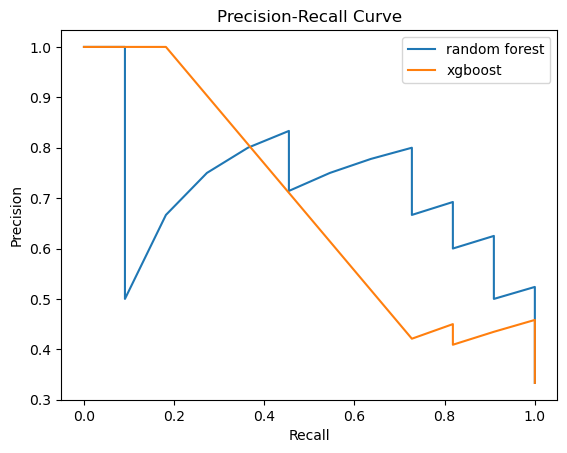

random forest AUC-PR: 0.7247405372405372
xgboost: 0.6879253582212809


In [92]:
y_test_proba_rf = search_rf.predict_proba(X_test_)
y_test_proba_xgb = search_xgb.predict_proba(X_test_)

y_score1 = y_test_proba_rf[:, 1]
y_score2 = y_test_proba_xgb[:, 1]
# y_true: true labels, y_score1: predicted scores of model 1, y_score2: predicted scores of model 2
precision1, recall1, _ = precision_recall_curve(y_test, y_score1)
precision2, recall2, _ = precision_recall_curve(y_test, y_score2)

# Plot the PR curves
plt.plot(recall1, precision1, label='random forest')
plt.plot(recall2, precision2, label='xgboost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Compute the AUC-PR scores
auc1 = auc(recall1, precision1)
auc2 = auc(recall2, precision2)

print('random forest AUC-PR:', auc1)
print('xgboost:', auc2)

At high presicion, random forest has slight better recall. Therefore, random forest is selected for our final model.

<a id="Summary"></a>
<h3 style="color:blue">3.7 Summary</h3>  

Use arbitrary value imputation missing value.

Do Categorical encoders tuning on 'state', choose WOEEncoder for now, with high Cross-Validation F1 Score. If there is enough time, need more time to try different encoder. WOEEncoder, are designed to handle categorical variables based on target information, making them suitable for classification problems.

Use Random Feature importance and permutation_importance to select features.

Run Random Forest and Xgboost model. RandomForestClassifier has overfitting problem, try Xgboost with regularization.

At high precision, random forest has slight better recall. Therefore, random forest is selected for our final model.

Threshold is optimized for higher precision and recall.
At threshold 0.63, precision is 87%, recall is 63%.



<a id='Fraud_type_Model'></a>
<h1 style="background-color:#fbcc54;font-family:monospace;font-size:200%;text-align:center">4. Fraud_type Model </h1>

<a id="Train/Test_data_ready_for_modeling2"></a>
<h3 style="color:blue">4.1 Train/Test data ready for modeling</h3>

Train Dataset: Used to fit the machine learning model.<br>
Test Dataset: Used to evaluate the fit machine learning model.

#### filter the fraud_type is null

In [93]:
df_type = df[df['fraud_type'].notnull()]
X = df_type.drop(['fraud_type','fraud_flag'], axis=1)
y = df_type['fraud_type']
le = preprocessing.LabelEncoder()
label_encoder = le.fit(y)
y = label_encoder.transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=5)

In [94]:
unique_values, counts = np.unique(y, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

0: 50
1: 5


#### there is not enough minority class to train the model.

<a id='Feature_Selection2'></a>
<h3 style="color:blue">4.1 Feature Selection</h3>

### Use feature_importances to select features

In [95]:
from imblearn.pipeline import Pipeline as ImbPipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1))])

state_transformer = Pipeline(steps=[('woe', ce.woe.WOEEncoder())])

binary_transformer = Pipeline(steps=[('ordinal', ce.ordinal.OrdinalEncoder())])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', state_transformer, ['state']),
    ('bin', binary_transformer, ['customer_ip_address'])
])

minmaxscaler = MinMaxScaler()

sampling = ADASYN(sampling_strategy='auto', random_state=0, n_neighbors=2)

pipe_with_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', minmaxscaler),
    ('sampling', sampling),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=5))])



In [96]:
# Fit the pipeline on the training data
pipe_with_smote.fit(X_train, y_train)

# Rest of the code to compute feature importances
importance_scores = pipe_with_smote.named_steps['classifier'].feature_importances_
sorted_scores = sorted(zip(importance_scores, X_train.columns), reverse=True)
k = 15
selected_features = [feature for (_, feature) in sorted_scores[:k]]
selected_features

['transaction_amount',
 'customer_ip_address',
 'payments_count',
 'orders_count',
 'payment_method_type_bitcoin',
 'payment_method_provider_Maestro',
 'transactions_count',
 'fraud_score',
 'payment_method_provider_VISA 16 digit',
 'transaction_failed',
 'state',
 'payment_method_provider_Voyager',
 'payment_method_provider_VISA 13 digit',
 'payment_method_provider_JCB 15 digit',
 'payment_method_provider_Diners Club / Carte Blanche']

### Use permutation_importance to select features

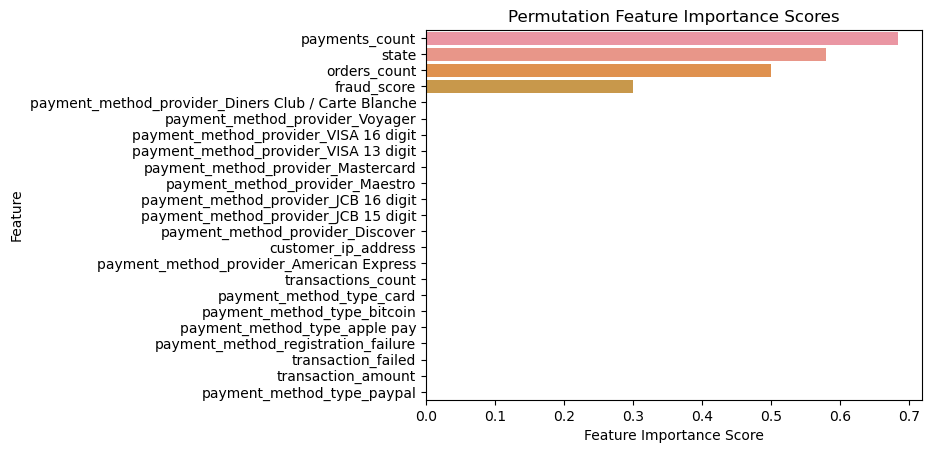

In [97]:
from sklearn.inspection import permutation_importance
r = permutation_importance(search_rf, X_test, y_test,
                           n_repeats=10,
                           random_state=0)
perm = pd.DataFrame(columns=['AVG_Importance'], index=[i for i in X_train.columns])
perm['AVG_Importance'] = r.importances_mean
# Sort the feature importance scores in descending order
perm = perm.sort_values(by='AVG_Importance', ascending=False)
# Create a bar plot of the feature importance scores
sns.barplot(x=perm['AVG_Importance'], y=perm.index)

# Add labels and title
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance Scores')
plt.show()

<a id='RandomForest_Predict_Fraud_type'></a>
<h3 style="color:blue">4.3 RandomForest Predict Fraud_type</h3>

In [100]:
X_train_ = X_train[selected_features]

X_test_ = X_test[selected_features]


### BorderlineSMOTE (address class imbalance)

BorderlineSMOTE is an extension of SMOTE that focuses on the borderline instances, which are samples that are near the decision boundary.

It identifies the samples that are borderline instances by considering their nearest neighbors and their class labels.

The objective is to provide better focus on the minority samples that are more challenging to classify correctly.

In [101]:
selected_numeric_features = [feature for feature in selected_features if feature not in ['state', 'customer_ip_address']]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1))])

state_transformer = Pipeline(steps=[('woe', ce.woe.WOEEncoder())])

binary_transformer = Pipeline(steps=[('ordinal', ce.ordinal.OrdinalEncoder())])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selected_numeric_features),
    ('cat', state_transformer, ['state']),
    ('bin', binary_transformer, ['customer_ip_address'])])

minmaxscaler = MinMaxScaler()

sampling = ADASYN(sampling_strategy='auto', random_state=0, n_neighbors=1)

pipe_with_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', minmaxscaler),
    ('sampling', sampling),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=5))])

param_grid = {
    'classifier__bootstrap': [True, False],
    'classifier__max_depth': [4, 6, 8, 10, 20, 30, 40],
    'classifier__min_samples_leaf': [4, 6, 8, 10, 12, 14],
    'classifier__min_samples_split': [2, 3, 4, 5, 6],
    'classifier__n_estimators': [100, 200, 300, 400]
}

# Set up the search
search_type = RandomizedSearchCV(
    pipe_with_smote,  # The model (corrected to use pipe_with_smote)
    param_grid,  # Hyperparameter space
    scoring='average_precision',  # Metric to optimize
    cv=2,  # Number of cross-validation folds
    random_state=5,  # Random seed for reproducibility
    refit=True,  # Fit the model with best hyperparameters to the entire training set after the search
)

# Find the best hyperparameters
search_type.fit(X_train_, y_train)

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(fill_value=-1,
                                                                                                              strategy='constant'))]),
                                                                               ['transaction_amount',
                                                                                'payments_count',
                                                                                'orders_count',
                                                                                'payment_method_type_bitcoin',
                                                                                'payment_method_provider_Maestro',
                                                                                'transactions_count',
                                                                                'fraud_score',
                                                                                'payment_meth...
                                             ('classifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=5))]),
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__max_depth': [4, 6, 8, 10,
                                                                  20, 30, 40],
                                        'classifier__min_samples_leaf': [4, 6,
                                                                         8, 10,
                                                                         12,
                                                                         14],
                                        'classifier__min_samples_split': [2, 3,
                                                                          4, 5,
                                                                          6],
                                        'classifier__n_estimators': [100, 200,
                                                                     300,
                                                                     400]},
                   random_state=5, scoring='average_precision')

In [102]:
# best hyperparameters
search_type.best_params_

{'classifier__n_estimators': 400,
 'classifier__min_samples_split': 4,
 'classifier__min_samples_leaf': 8,
 'classifier__max_depth': 10,
 'classifier__bootstrap': True}

In [103]:
X_train_preds_rf = search_type.predict_proba(X_train_)[:,1]
X_test_preds_rf = search_type.predict_proba(X_test_)[:,1]

print('Train roc_auc: ', roc_auc_score(y_train, X_train_preds_rf))
print('Test roc_auc: ', roc_auc_score(y_test, X_test_preds_rf))

Train roc_auc:  0.81875
Test roc_auc:  1.0


In [104]:
y_test_pred_rf = search_type.predict(X_test_)
y_train_pred_rf = search_type.predict(X_train_)

print('report for random forest training set')
print("====================================")
print(classification_report(y_train, y_train_pred_rf))
print('report for random forest testing set')
print("====================================")
print(classification_report(y_test, y_test_pred_rf))

report for random forest training set
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        40
           1       0.17      0.25      0.20         4

    accuracy                           0.82        44
   macro avg       0.54      0.56      0.55        44
weighted avg       0.85      0.82      0.83        44

report for random forest testing set
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.00      0.00      0.00         1

    accuracy                           0.91        11
   macro avg       0.45      0.50      0.48        11
weighted avg       0.83      0.91      0.87        11



C:\Users\xzhu5\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xzhu5\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xzhu5\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


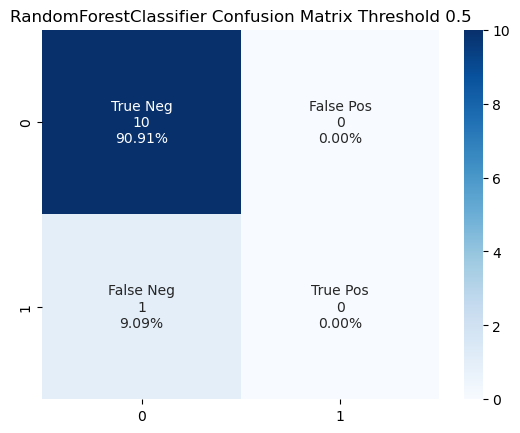

In [105]:
cmv = ConfusionMatrixVisualizer(search_type, X_test_, y_test, title='RandomForestClassifier Confusion Matrix Threshold 0.5')
cmv.generate_confusion_matrix()

C:\Users\xzhu5\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xzhu5\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xzhu5\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xzhu5\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_cl

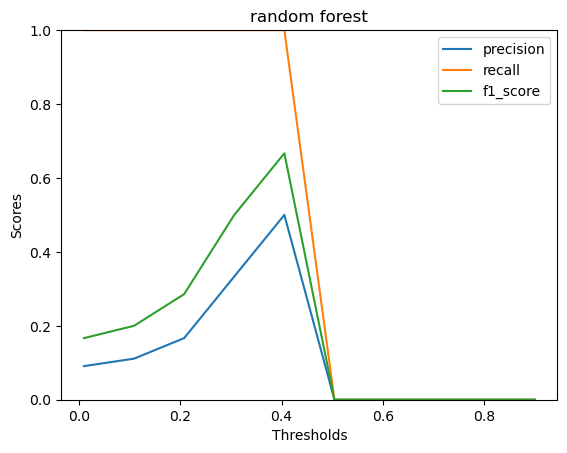

In [106]:
model_evaluator = ModelEvaluatorThreshold(search_type, X_train_, X_test_, y_train, y_test)
model_evaluator.evaluate('random forest')

In [114]:
y_pred_opt_0 = (search_type.predict_proba(X_test_)[:, 1] > 0.4).astype('float')
confusion_matrix(y_test, y_pred_opt_0)

array([[9, 1],
       [0, 1]], dtype=int64)

From the fig we see that precision and recall go up and down with the increasing of threshold.

At threshold =0.33, both presicion and recall are relative high.

Out of all 11 fraud cases, the classifier predicted 2 positive (type2), 1 is correct.

There are 9 predicted negtive (type1), all of the prediction are correct.

In [115]:
precision = precision_score(y_test, y_pred_opt_0)
recall = recall_score(y_test, y_pred_opt_0)

print(f"Precision at threshold {0.4}: {precision}")
print(f"Recall at threshold {0.4}: {recall}")

Precision at threshold 0.4: 0.5
Recall at threshold 0.4: 1.0


<a id='Summary2'></a>
<h3 style="color:blue">4.4 Summary</h3>

Use arbitrary value imputation missing value.

Use ADASYN/BorderlineSMOTE to address class imbalance.

Use Random Feature importance and permutation_importance to select features.

Threshold is optimized for higher precision and recall.

At threshold =0.35, Random Forest with precision 100%, recall 100%.



<a id='Conclusion'></a>
<h1 style="background-color:#fbcc54;font-family:monospace;font-size:200%;text-align:center">5. Conclusion </h1>

If there are more time, I will write a preprocessor for data clean, run SHAP to see Global/local feature importance. 

If there are more time, I will be understanding more about the IP address to get the geographic location associated with the transaction, if it is matches with the customer address.

Additional data may be helpful, the Customer demographics (Age, job, housing…), Customer behavior (shopping history).
